In [108]:
#Depenencies

# Import required libraries/packages

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns             
import gc
from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,roc_auc_score,classification_report,roc_curve,auc, f1_score

#Import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb

#import library for hyperparameter optimization
from hyperopt import STATUS_OK
from hyperopt import hp, tpe, Trials, fmin
from hyperopt.pyll.stochastic import sample

import featuretools as ft 
from featuretools import selection


In [10]:
#collected all files

# File system manangement

os.chdir("D:/BA EDA Assignment/allData/") # set the working directory

For the feature, city not working city, we see that there are more loans are taken by those working in same city (0) and they are more defaulted by those who don't work in same city

In [11]:
appBase=pd.read_csv("applications_base.csv")
bureau=pd.read_csv("bureau.csv")

In [12]:
#scanning number of rows and columns in each Excel

print ("application_base:",appBase.shape)
print ("bureau:",bureau.shape)

application_base: (307511, 122)
bureau: (1716428, 17)


In [13]:
#Scanning headers of each excel

display("application_Base")
display(appBase.head(3))
display("bureau")
display(bureau.head(3))

'application_Base'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  

[3 rows x 122 columns]

'bureau'

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN

There are 282686 loans repaid on time (TARGET=0) and 24825 loans defaulted (TARGET=1) in the dataset


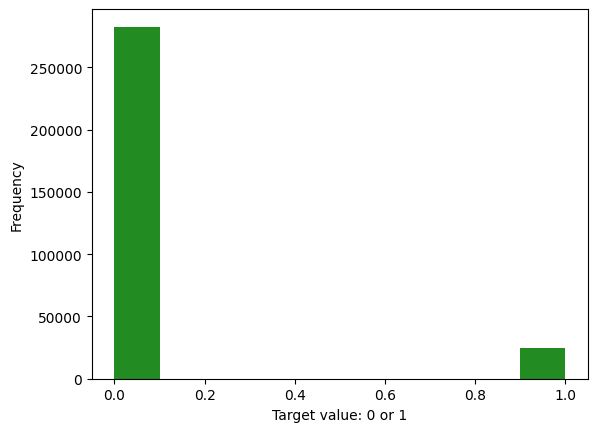

In [14]:
# Target data distribution

appBase['TARGET'].astype(int).plot.hist(color='forestgreen').set_xlabel('Target value: 0 or 1');

count = appBase['TARGET'].value_counts()
num_repaid = count[0]
num_default = count[1]

print("There are {} loans repaid on time (TARGET=0) and {} loans defaulted (TARGET=1) in the dataset".format(num_repaid, num_default))

(0.0, 100.0)

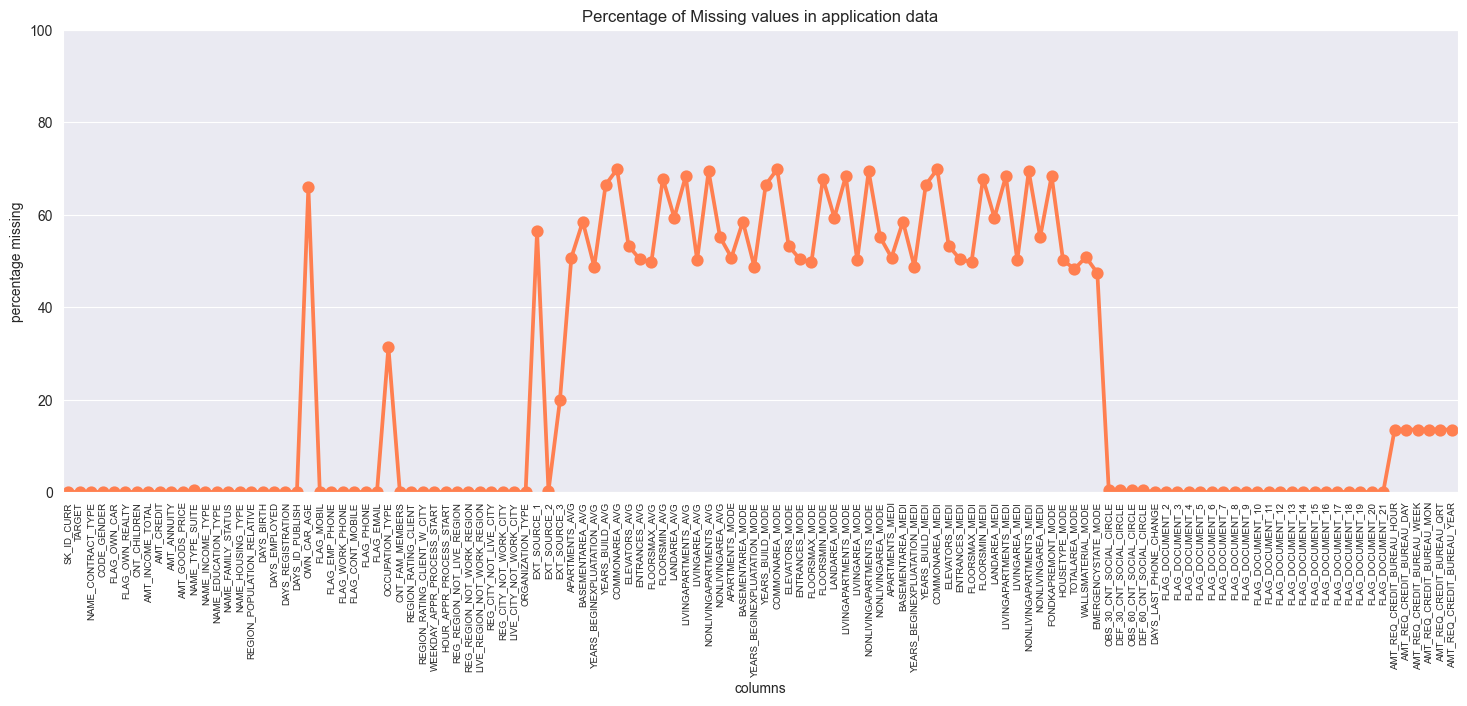

In [16]:
# Missing data in application (main) dataset

fig = plt.figure(figsize=(18,6))
miss_data = pd.DataFrame((appBase.isnull().sum())*100/appBase.shape[0]).reset_index()
miss_data["type"] = "application data"
sns.set_style('darkgrid')
ax = sns.pointplot(x="index", y=0, data=miss_data, color='coral')

plt.xticks(rotation =90,fontsize =7)
plt.title("Percentage of Missing values in application data")
plt.ylabel("percentage missing")
plt.xlabel("columns")
plt.ylim((0,100))

In the appBase dataset, we can see that there are a number of features with missing values almost 50%. The features with missing data need to be discarded or missing values filled before training any model. Similar checks should be performed on the other datasets.

(0.0, 100.0)

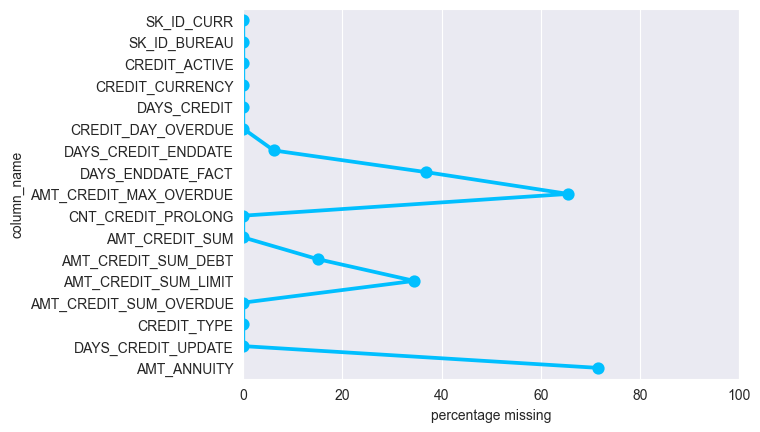

In [22]:
# Missing data in other data

missing_data_df = pd.DataFrame(bureau.isnull().sum() / bureau.shape[0] * 100).reset_index()
missing_data_df.columns = ['column_name', 'missing_percentage']  # Rename columns for clarity

sns.pointplot(x="missing_percentage", y="column_name", data=missing_data_df, color='deepskyblue')
plt.xlabel("percentage missing")
plt.xlim((0, 100))


In [24]:
def plot_bar_gen(feature, df = None, orientation_horizontal = True):
    
    if df is None:
        df = appBase
    else:
        df = df
    
    temp = df[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = df[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    sns.set_color_codes("colorblind")
    
    if orientation_horizontal == True:
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        s1 = sns.barplot(y = feature, x="Number of contracts",data=df1)
        plt.subplot(122)
        s2 = sns.barplot(y = feature, x='TARGET', data=cat_perc)
        plt.xlabel('Fraction of loans defaulted', fontsize=12)
        plt.ylabel(feature, fontsize=12)
        
    else:
        plt.figure(figsize=(10,18))
        plt.subplot(211)
        s1 = sns.barplot(x = feature, y="Number of contracts",data=df1)
        s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
        plt.subplot(212)
        s2 = sns.barplot(x = feature, y='TARGET', data=cat_perc)
        s2.set_xticklabels(s2.get_xticklabels(),rotation=90)
        plt.ylabel('Fraction of loans defaulted', fontsize=12)
        plt.xlabel(feature, fontsize=12)
    
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.subplots_adjust(wspace = 0.6)
    plt.show();

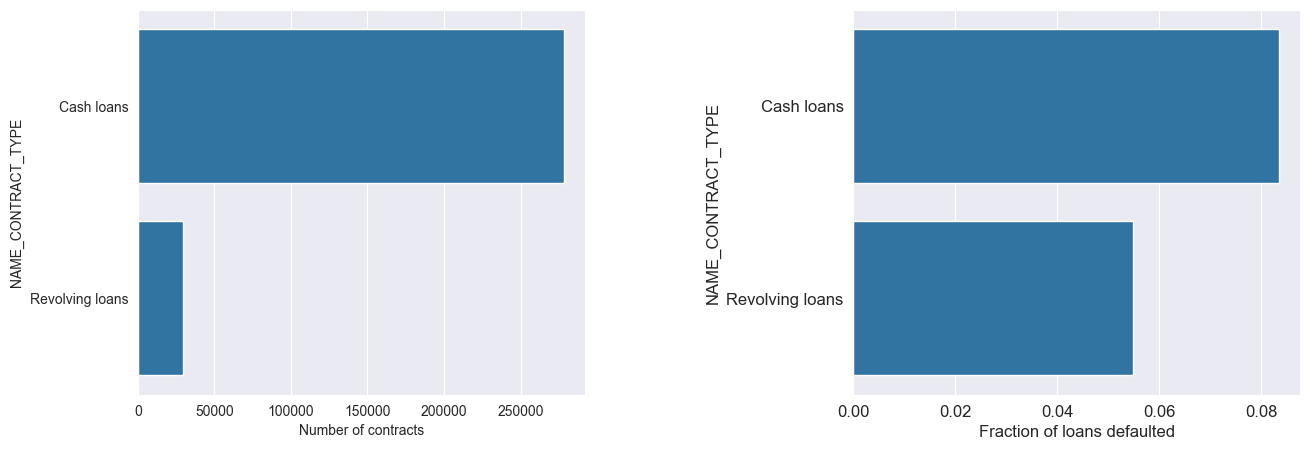

In [25]:
plot_bar_gen('NAME_CONTRACT_TYPE')

For the feature, type of contract, we see that there are more cash loans taken than revolving loans and they are also more defaulted.

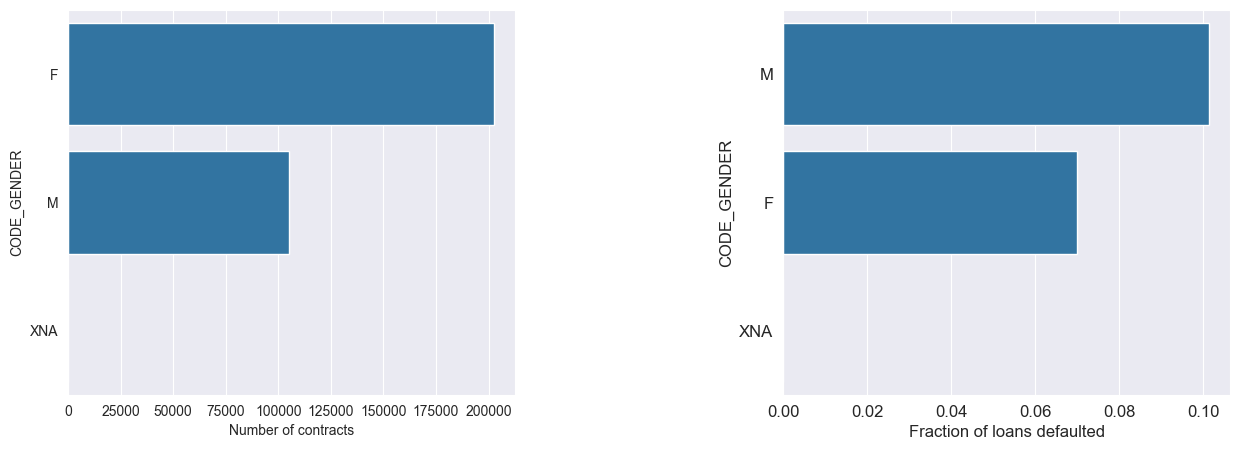

In [26]:
plot_bar_gen('CODE_GENDER')

For the feature, gender, we see that there are more loans taken by males and they are also more defaulted by them.

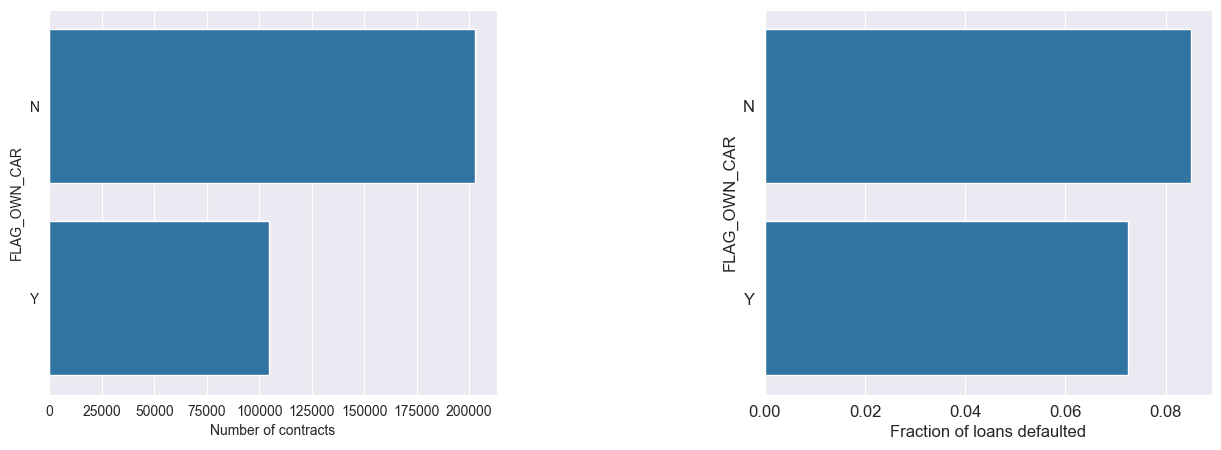

In [27]:
plot_bar_gen('FLAG_OWN_CAR')

For the feature, owning car, we see that there are more loans taken by those without car and they are also more defaulted by them.

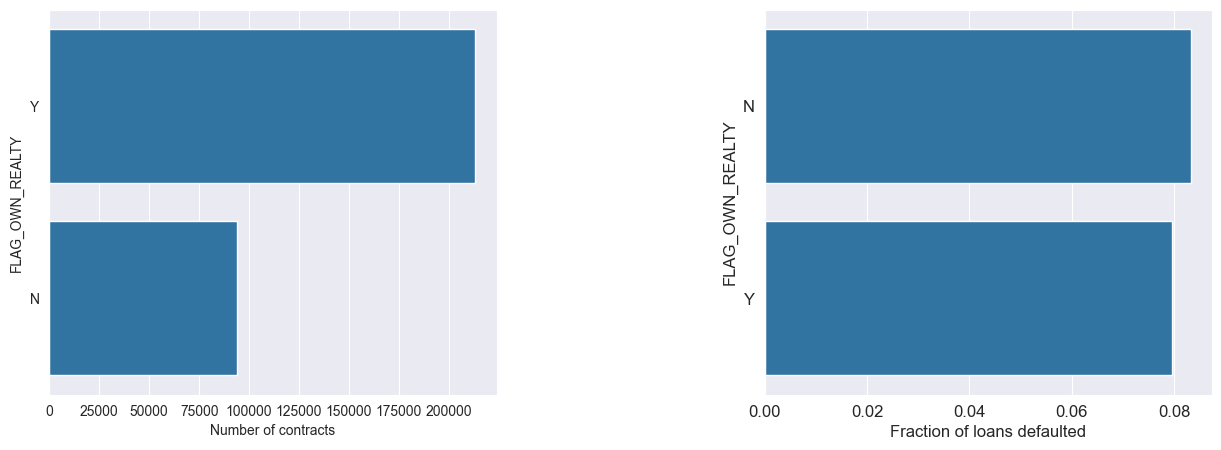

In [28]:
plot_bar_gen('FLAG_OWN_REALTY')

For the feature, owning realty, we see that there are more loans taken by those with realty and they are defaulted slightly more by those without realty.

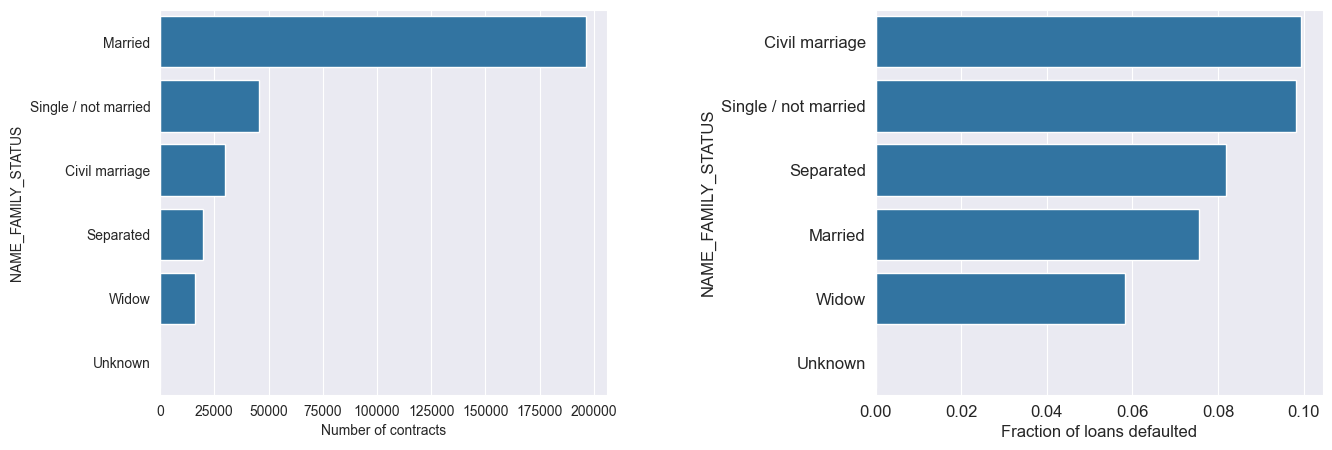

In [29]:
plot_bar_gen('NAME_FAMILY_STATUS')

For the feature, family status, we see that there are more loans taken by those who are married and they are more defaulted by those who are in a civil marriage/single

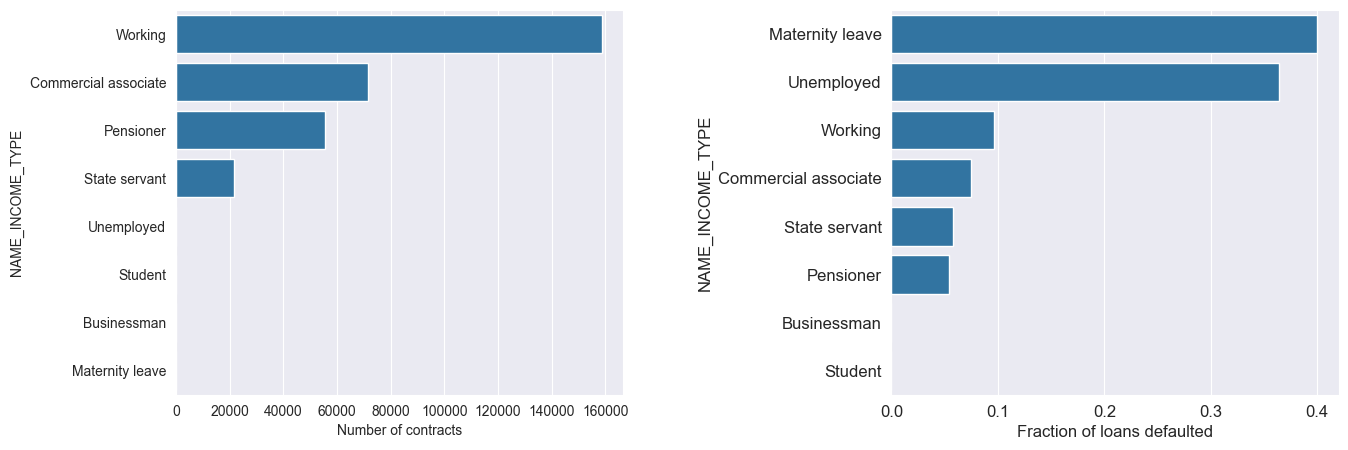

In [30]:
plot_bar_gen('NAME_INCOME_TYPE')

For the feature, income type, we see that there are more loans taken by those who are working and they are more defaulted by those who are on maternity leave or unemployed

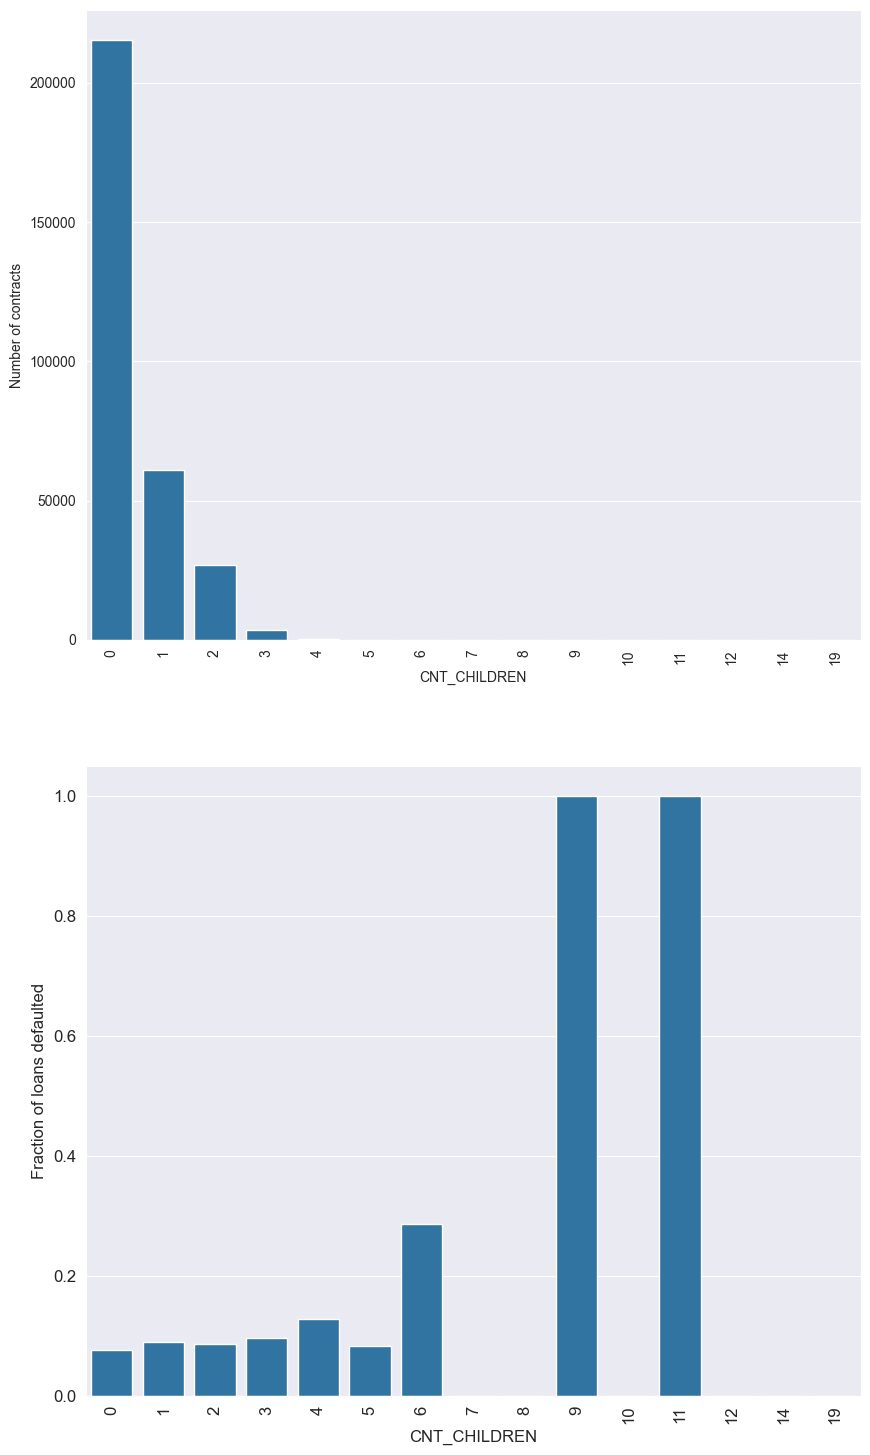

In [31]:
plot_bar_gen('CNT_CHILDREN',None,False)

For the feature, children count, we see that there are more loans taken by those who have fewer children and they are more defaulted by those who have more children

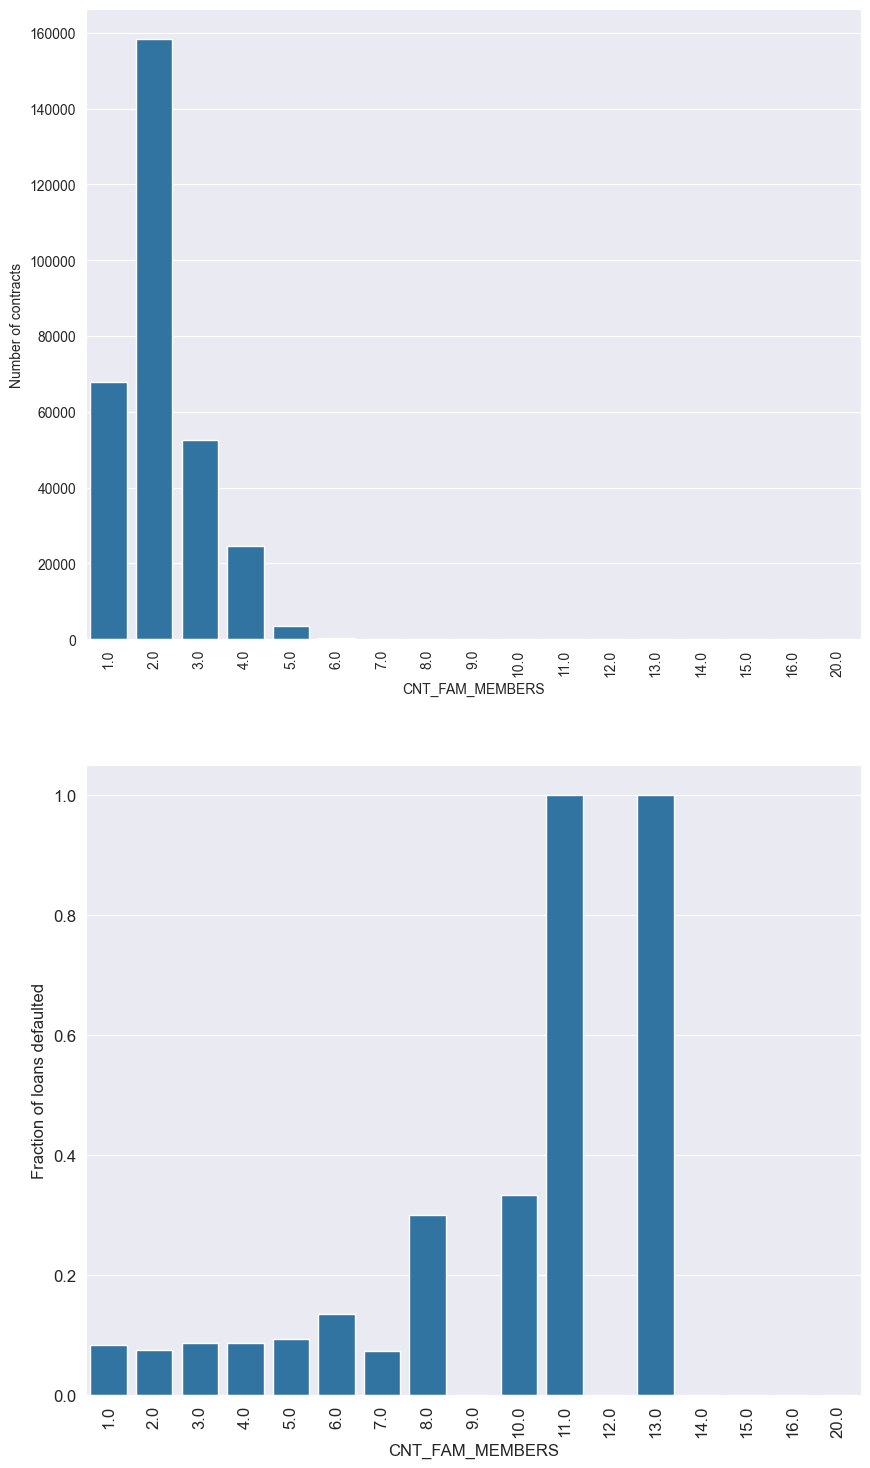

In [32]:
plot_bar_gen('CNT_FAM_MEMBERS',None,False)

For the feature, family member count, we see that there are more loans taken by those who have fewer family member and they are more defaulted by those who have more members

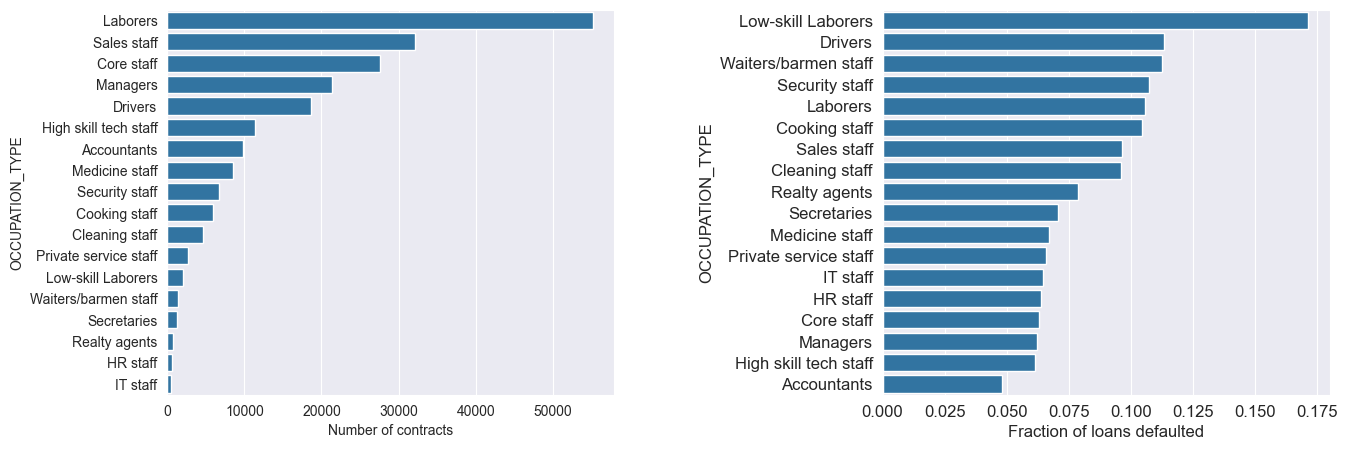

In [33]:
plot_bar_gen('OCCUPATION_TYPE')

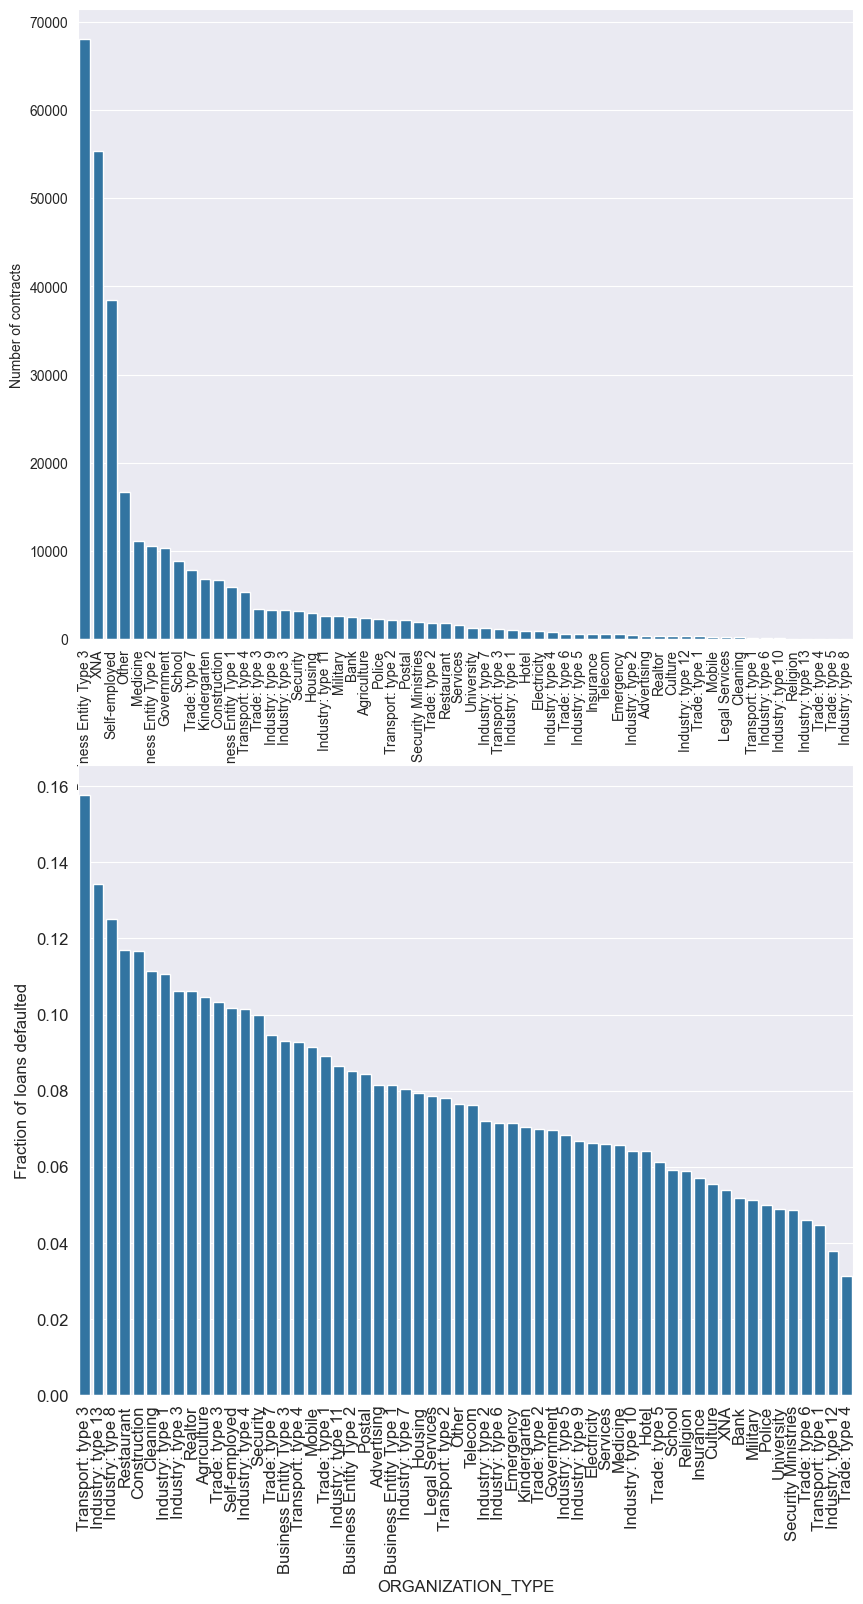

In [34]:
plot_bar_gen('ORGANIZATION_TYPE',None,False)

For the feature, occupation type, we see that there are more loans taken categories like laborers and they are more defaulted by them too

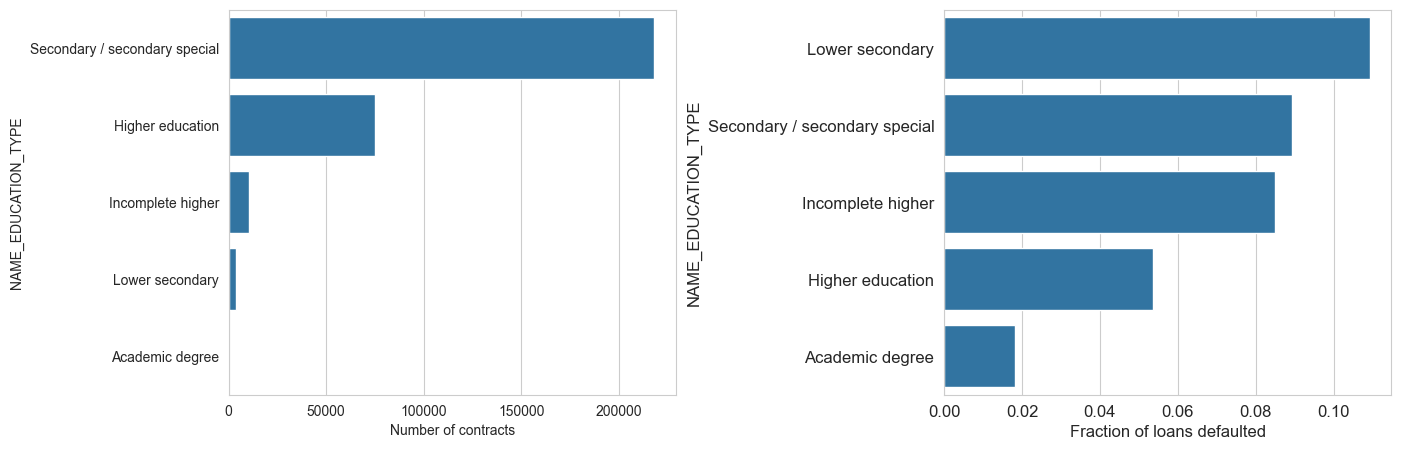

In [43]:
plot_bar_gen('NAME_EDUCATION_TYPE')

For the feature, education type, we see that there are more loans taken by those with secondary education and they are more defaulted by those who have less education

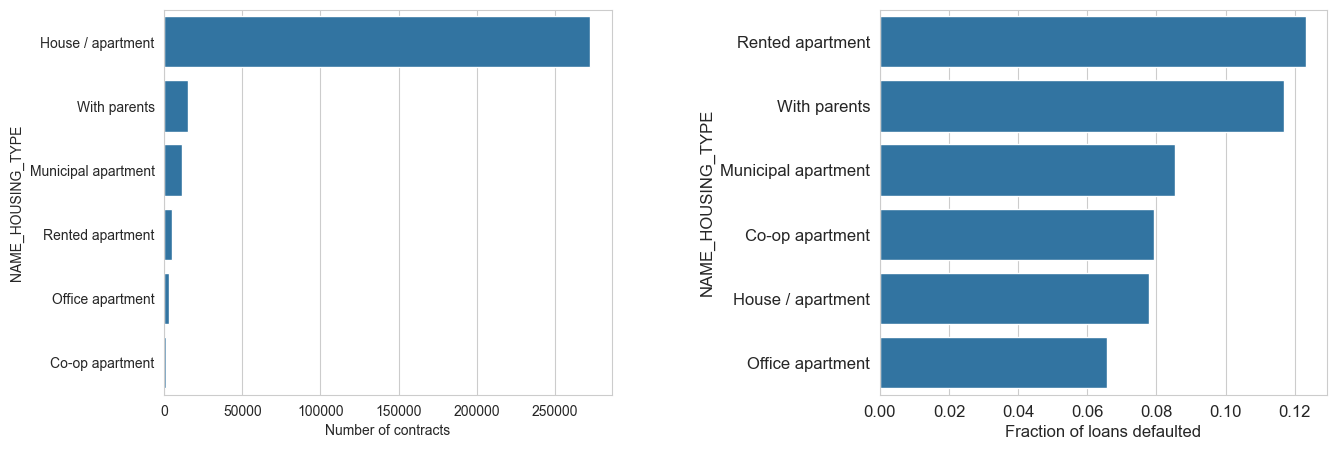

In [42]:
plot_bar_gen('NAME_HOUSING_TYPE')

For the feature, housing type, we see that there are more loans taken by those with a house/apartment and they are more defaulted by those who have rented apartment or live with parents

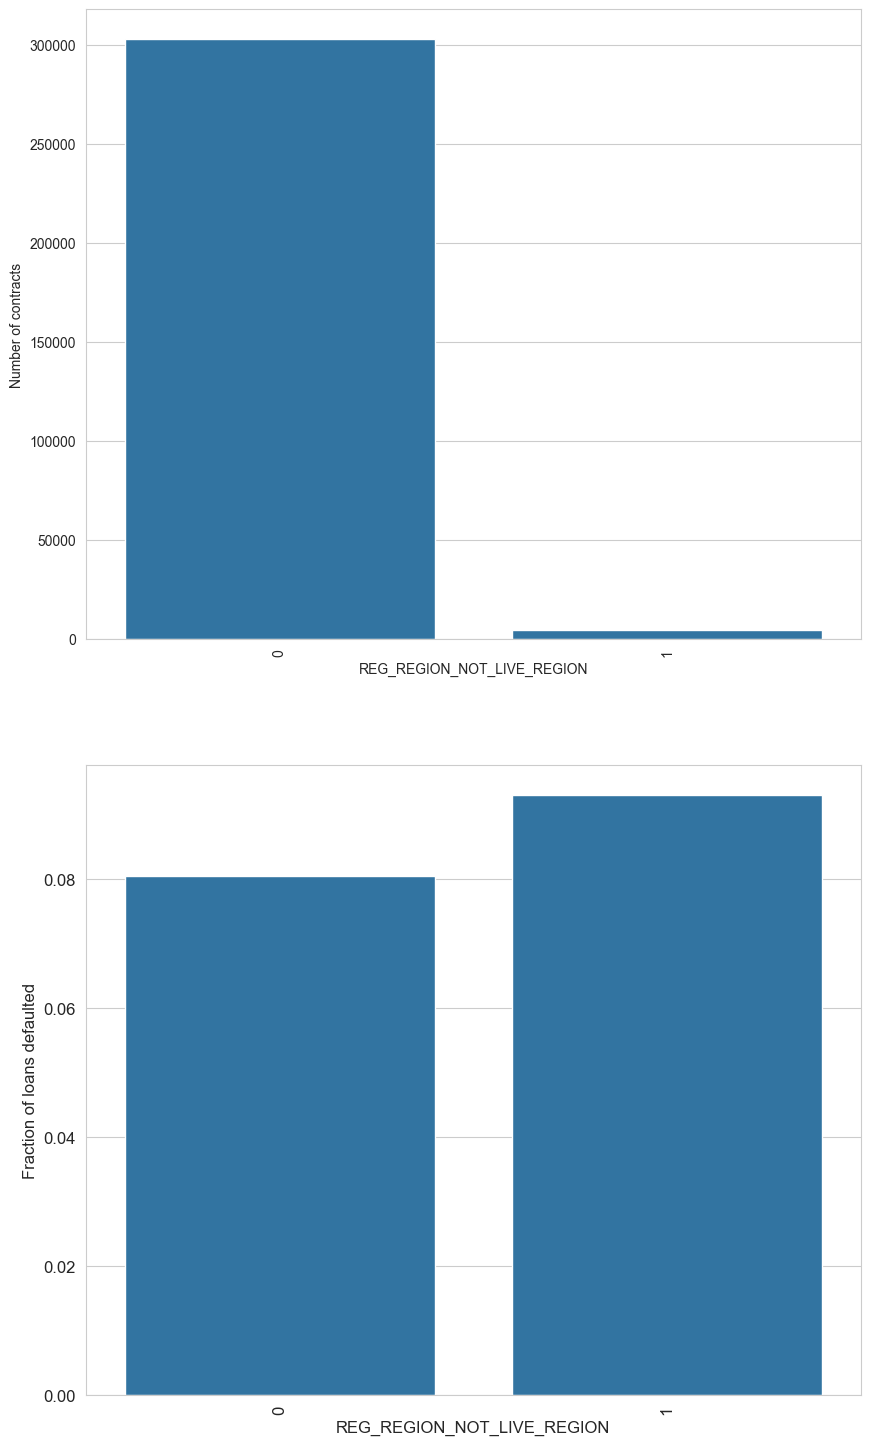

In [41]:
plot_bar_gen('REG_REGION_NOT_LIVE_REGION',None,False)

For the feature, region not living region, we see that there are more loans are taken by those living in same region (0) and they are more defaulted by those who don't live in same region

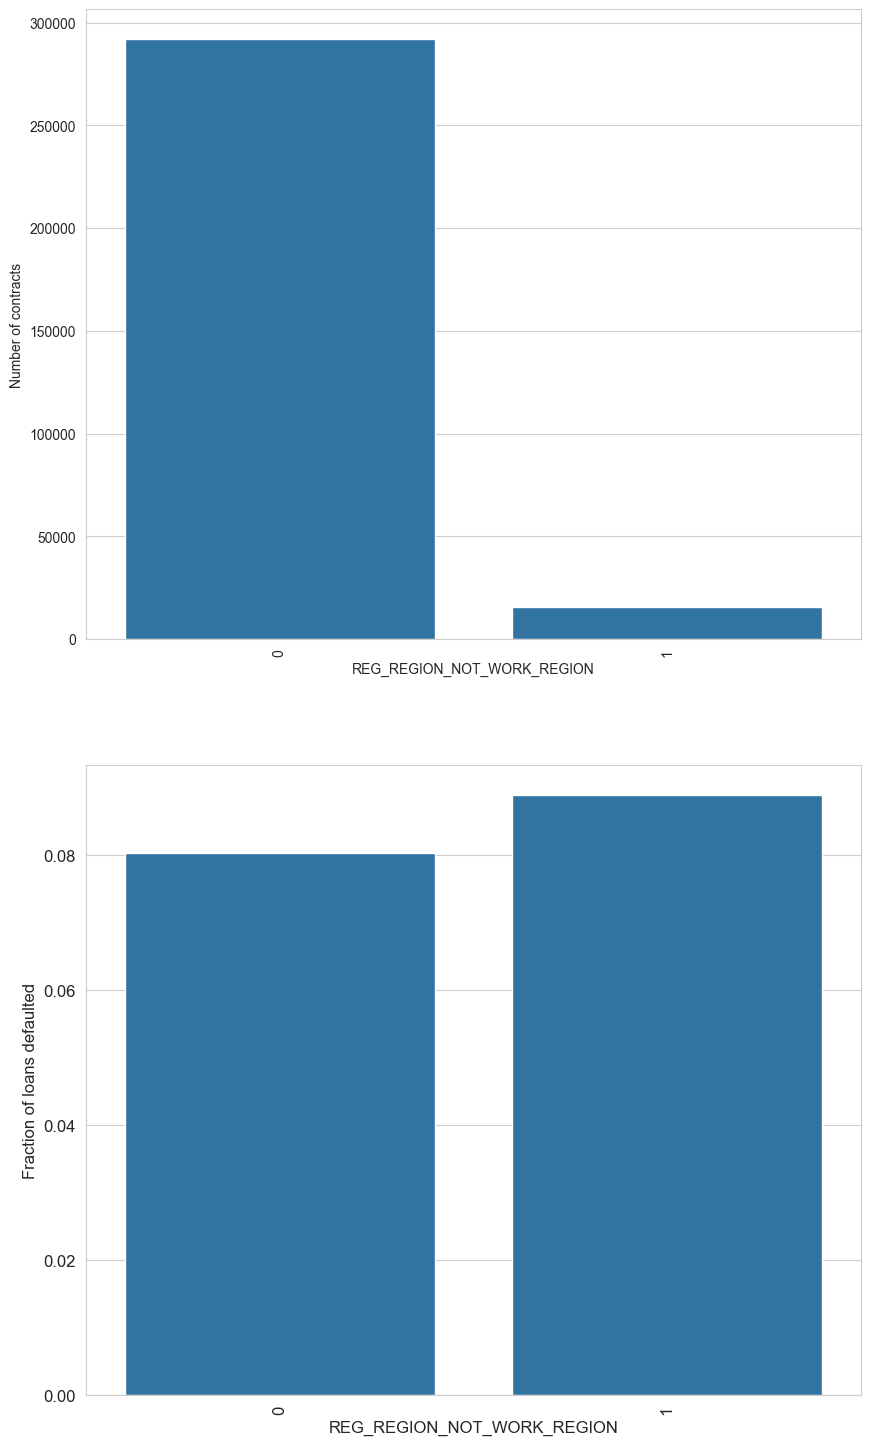

In [40]:
plot_bar_gen('REG_REGION_NOT_WORK_REGION',None,False)

For the feature, region not work region, we see that there are more loans are taken by those working in same region (0) and they are more defaulted by those who don't work in same region

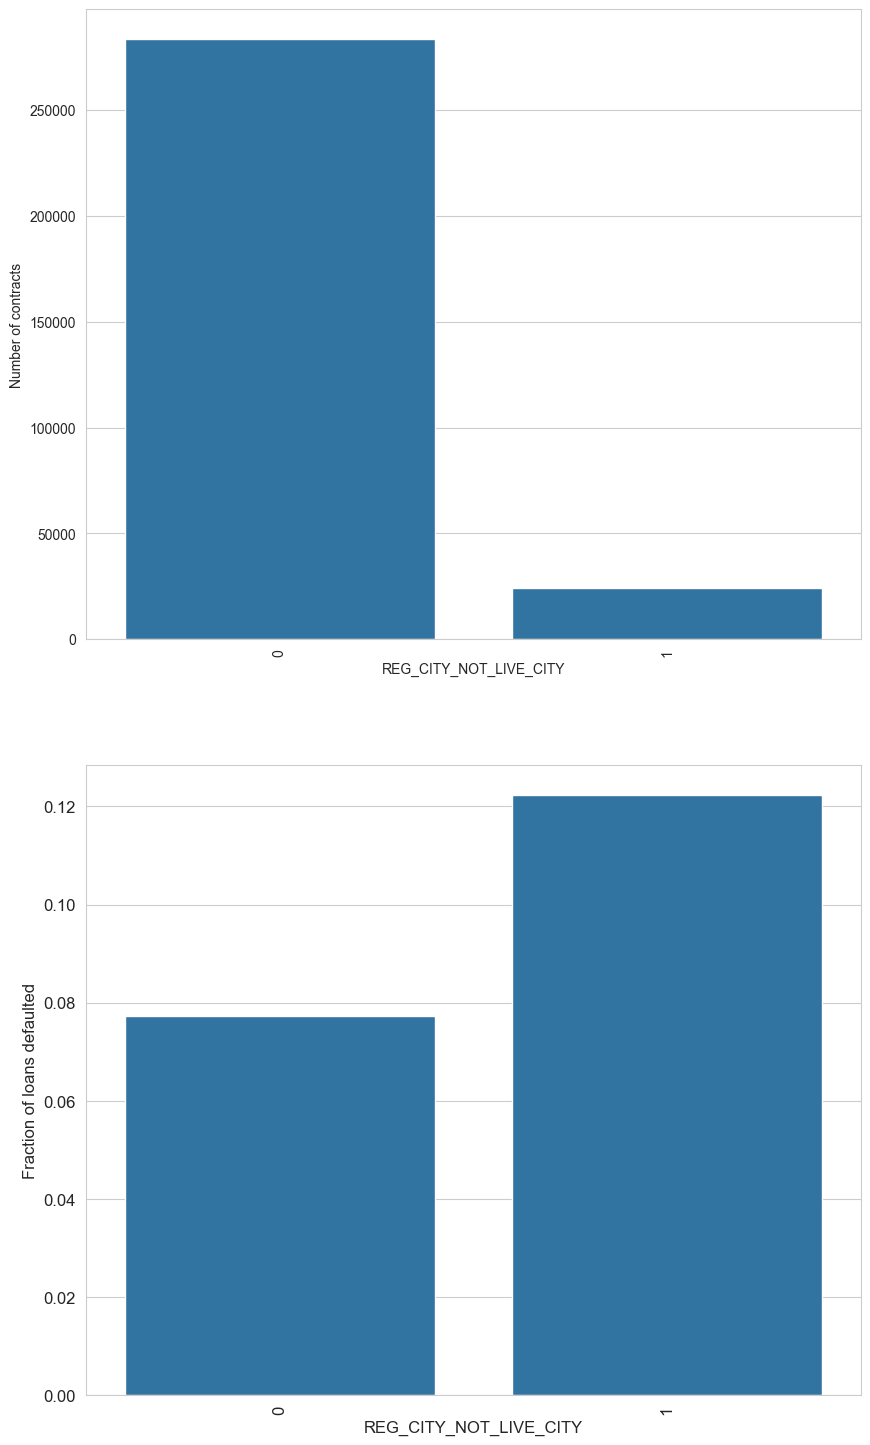

In [39]:
plot_bar_gen('REG_CITY_NOT_LIVE_CITY',None,False)

For the feature, city not living city, we see that there are more loans are taken by those living in same city (0) and they are more defaulted by those who don't live in same city

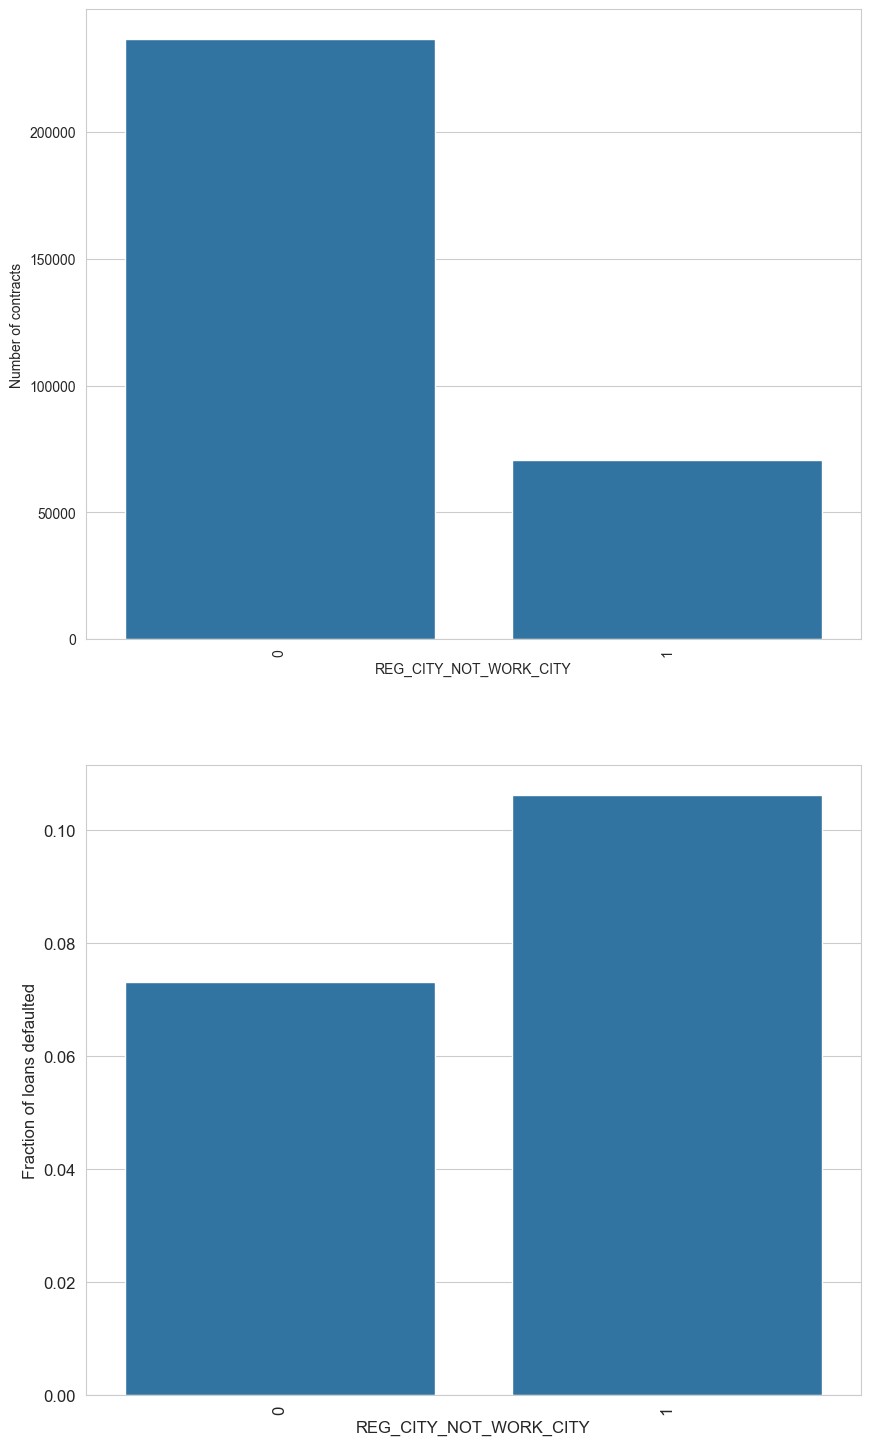

In [38]:
plot_bar_gen('REG_CITY_NOT_WORK_CITY',None,False)

For non-categorical features, we can plot bivariate distributions (with TARGET) to see if there is difference when loan is repaid or defaulted

In [35]:
# Plot distribution of one feature with or without paid/default shown separately

def plot_distribution_gen(feature,df=None,separate_target=False):
    if df is None:
        df = appBase
    else:
        df = df
        
    if separate_target == False:
        plt.figure(figsize=(10,6))
        plt.title("Distribution of %s" % feature)
        sns.distplot(df[feature].dropna(),color='red', kde=True,bins=100)
    else:
        t1 = df.loc[df['TARGET'] != 0]
        t0 = df.loc[df['TARGET'] == 0]
        
        plt.figure(figsize=(10,6))
        plt.title("Distribution of %s" % feature)
        sns.set_style('whitegrid')
#         sns.kdeplot(t1[feature], bw=0.5,label="Loan defaulted (TARGET=1)")
#         sns.kdeplot(t0[feature], bw=0.5,label="Loan repaid (TARGET = 0)")
        
        sns.kdeplot(df.loc[df['TARGET'] == 0, feature], label = 'target == 0')
        sns.kdeplot(df.loc[df['TARGET'] == 1, feature], label = 'target == 1')
    
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        plt.legend(loc="best", labels=['Loan repaid (TARGET=0)', 'Loan defaulted (TARGET=1)'])
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

The function below can be used to identify outliers in the data distribution

In [36]:
def get_thresh(feature):
    """ Outliers are usually > 3 standard deviations away from the mean. """
    ave=np.mean(appBase[feature])
    sdev=np.std(appBase[feature])
    threshold=round(ave+(3*sdev),2)
    print('Threshold for',feature,':',threshold)
    return threshold

The function below can be used to identify outliers in the data distribution

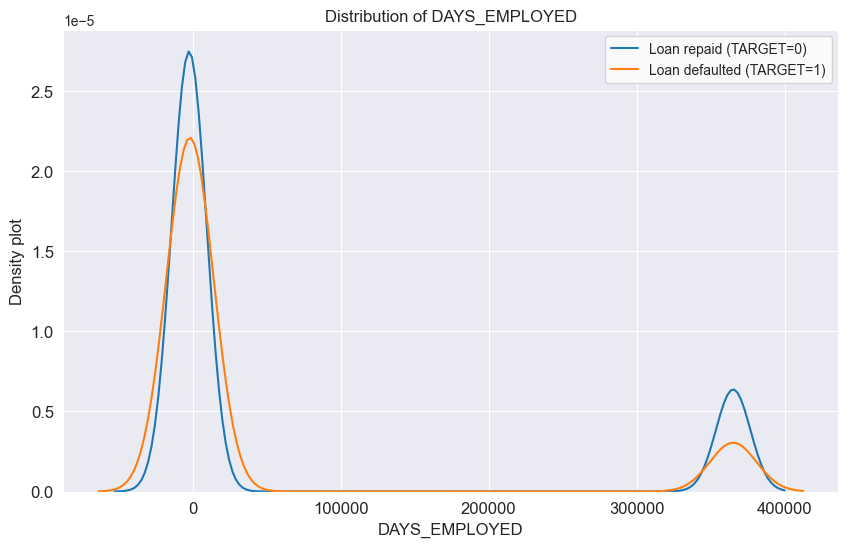

In [37]:
plot_distribution_gen('DAYS_EMPLOYED',None,True)

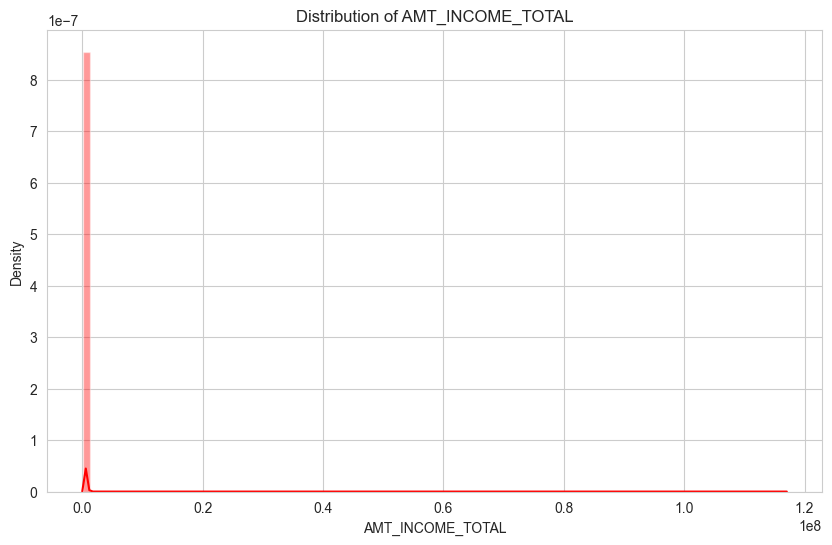

In [44]:
plot_distribution_gen('AMT_INCOME_TOTAL')

For the feature, amount income total, we see that there is an issue in the data, possibly due to outliers. This needs to be corrected

In [45]:
thresh_income = get_thresh('AMT_INCOME_TOTAL')
thresh_employment = get_thresh('DAYS_EMPLOYED')

anomalous_employment = appBase[appBase['DAYS_EMPLOYED'] > 0]
normal_employment = appBase[appBase['DAYS_EMPLOYED'] < 0]

print('The non-anomalies default on %0.2f%% of loans' % (100 * normal_employment['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anomalous_employment['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anomalous_employment))

Threshold for AMT_INCOME_TOTAL : 880166.2
Threshold for DAYS_EMPLOYED : 487641.66
The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


In [47]:
# Replace the anomalous values with nan

appBase['DAYS_EMPLOYED'].mask(appBase['DAYS_EMPLOYED'] > 0, inplace=True)
appBase['AMT_INCOME_TOTAL'].mask(appBase['AMT_INCOME_TOTAL'] > thresh_income, inplace=True)

In [48]:
def create_day_to_year(df,ls_cols,newcol):
    df[newcol] = round(np.abs(df[ls_cols[0]]/365))
    df.drop(columns=ls_cols,inplace=True);
    return df

For the feature, AGE, we can see that there are more number of loans defaulted by younger people

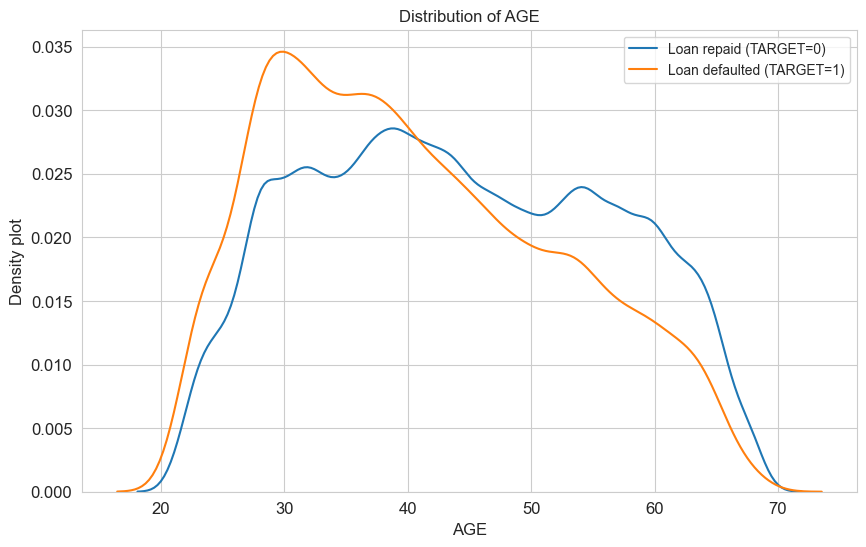

In [50]:
create_day_to_year(appBase,['DAYS_BIRTH'],'AGE');
plot_distribution_gen('AGE',None,True)

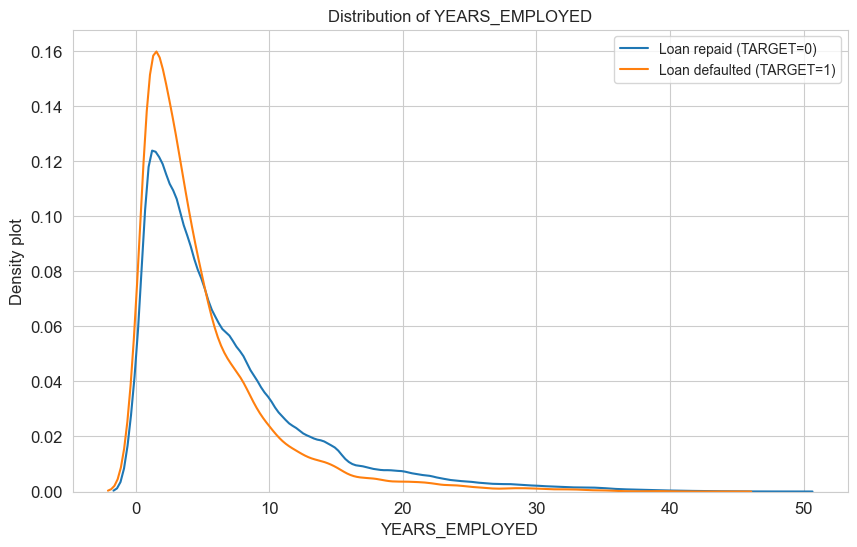

In [52]:
create_day_to_year(appBase,['DAYS_EMPLOYED'],'YEARS_EMPLOYED');
plot_distribution_gen('YEARS_EMPLOYED',None,True)

For the feature, AGE, we can see that there are more number of loans defaulted by younger people

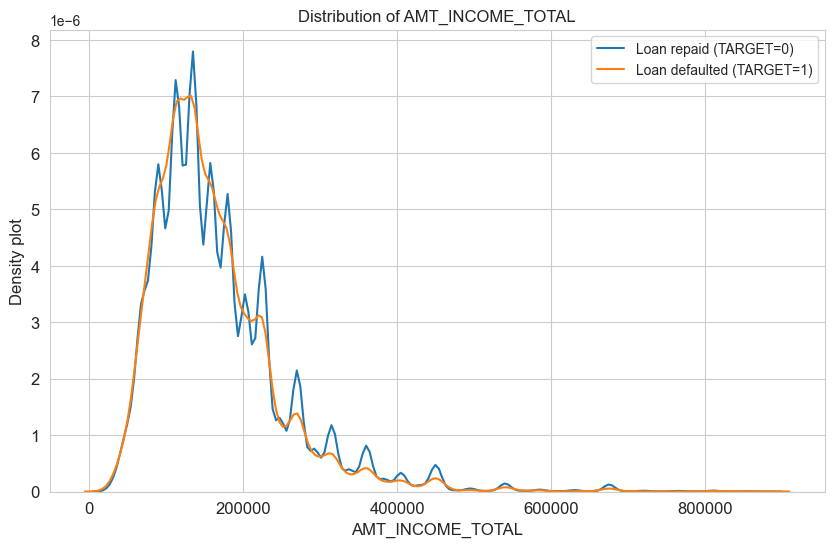

In [53]:
plot_distribution_gen('AMT_INCOME_TOTAL',None,True)

Now we can revisit the total income feature after removing outliers and we see the minor differences in distributions when loans are repaid or defaulted.

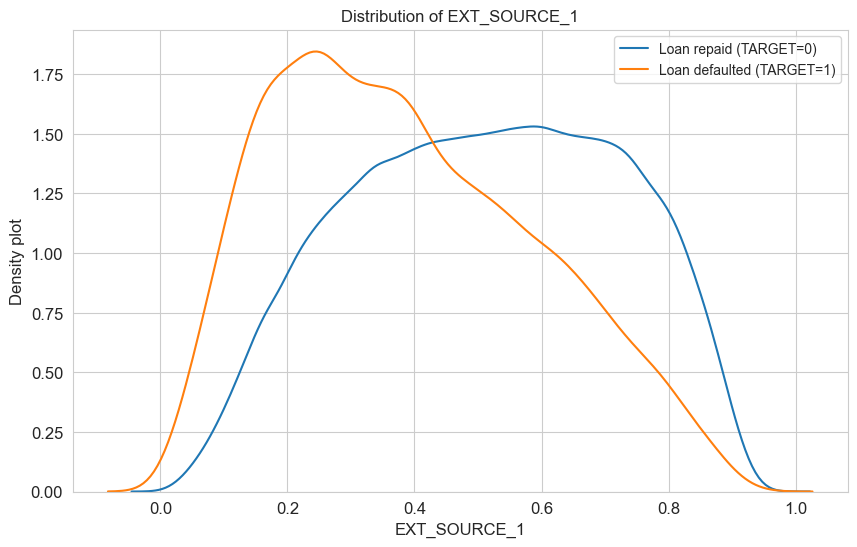

In [54]:
plot_distribution_gen('EXT_SOURCE_1',None,True)

For the feature, EXT_SOURCE_1, we can see that as value of EXT_SOURCE_1 increases, the probability of loan being repaid also increases.

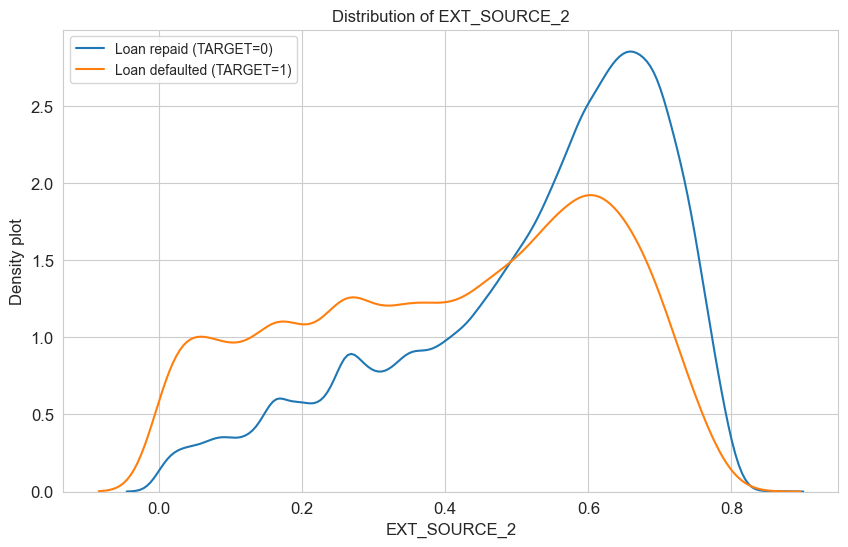

In [55]:
plot_distribution_gen('EXT_SOURCE_2',None,True)

For the feature, EXT_SOURCE_2, we can see that as value of EXT_SOURCE_2 increases, the probability of loan being repaid also increases.

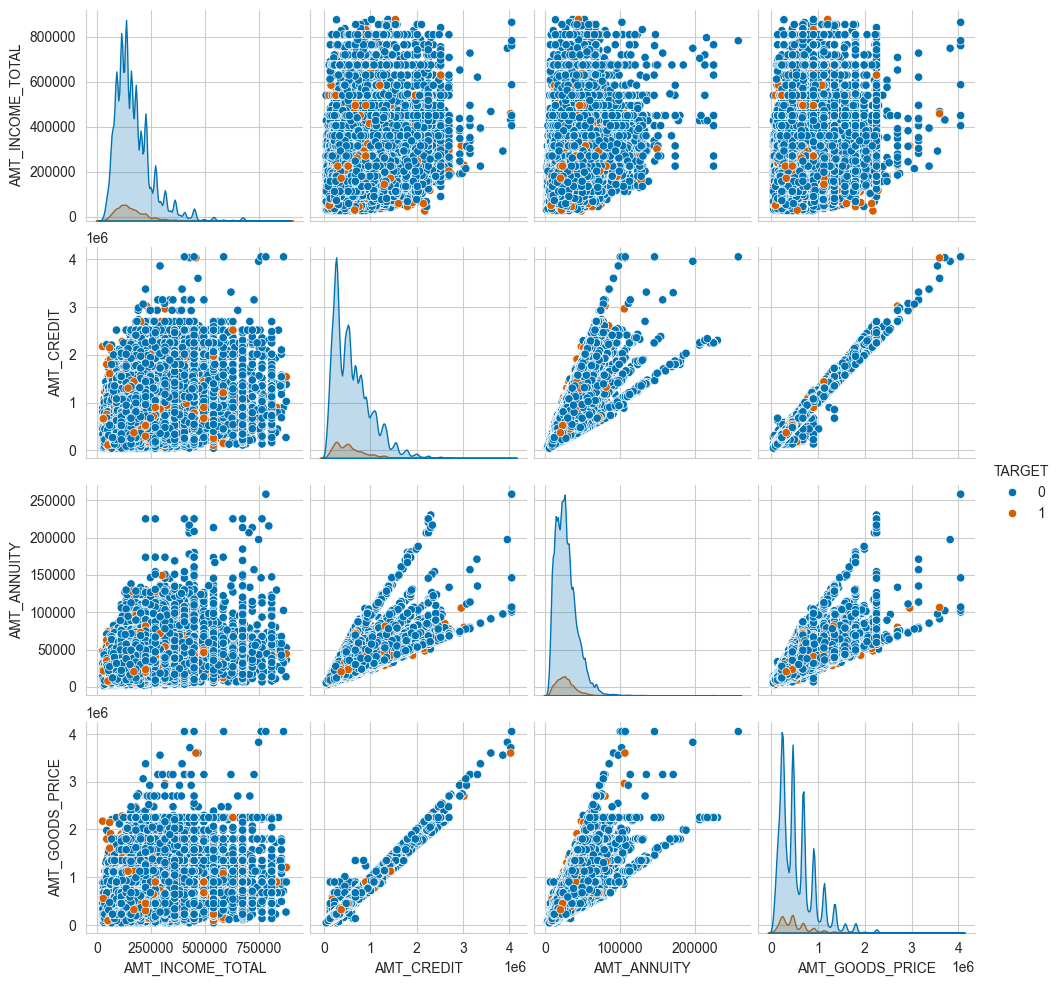

In [57]:
amt = appBase[[ 'AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY', 'AMT_GOODS_PRICE',"TARGET"]]
amt = amt[(amt["AMT_GOODS_PRICE"].notnull()) & (amt["AMT_ANNUITY"].notnull())]
g = sns.pairplot(amt,hue="TARGET",palette=["b","r"])  

plt.show()

All the features related to amount ('AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY', 'AMT_GOODS_PRICE') can be plotted along with TARGET as a heatmap to see if there are any possible correlations. We see in most cases that the repaid loans (TARGET = 0) have higher values.

In [59]:
create_day_to_year(appBase,['DAYS_REGISTRATION'],'YEARS_REGISTRATION');

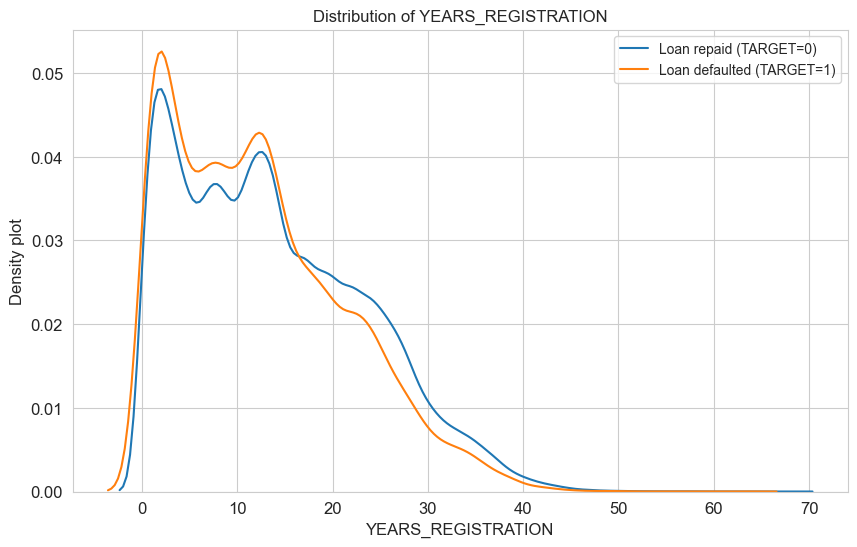

In [60]:
plot_distribution_gen('YEARS_REGISTRATION',None,True)

For the feature, YEARS_REGISTRATION, we can see that there are more number of loans defaulted for lower number of years

In [62]:
create_day_to_year(appBase,['DAYS_ID_PUBLISH'],'YEARS_ID_PUBLISH');

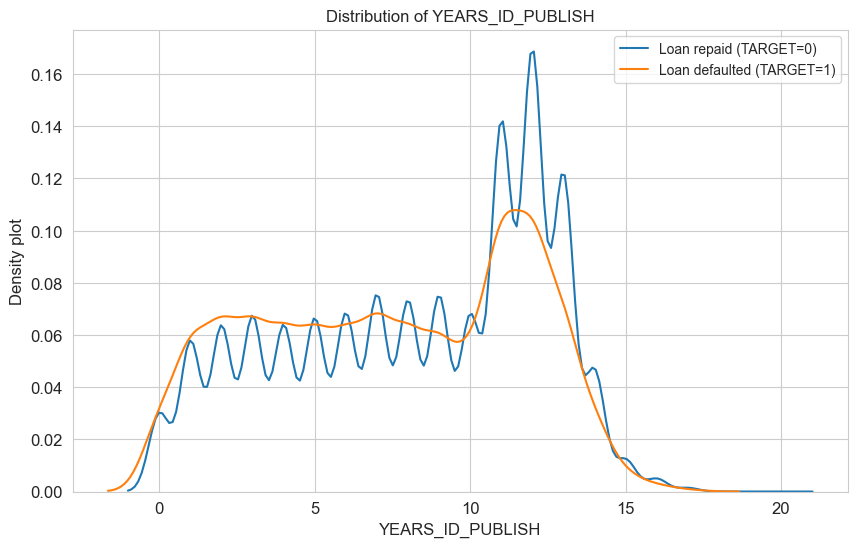

In [63]:
plot_distribution_gen('YEARS_ID_PUBLISH',None,True)

For the feature, YEARS_ID_PUBLISH, we can see that there are more number of loans defaulted for lower number of years

The below function can create income bands for the individuals using income ranges from income total

In [64]:
# Create INCOME_BAND to group individuals per income range

def create_income_band(df):
    df.loc[(df.AMT_INCOME_TOTAL < 30000),'INCOME_BAND'] = 1
    df.loc[(df.AMT_INCOME_TOTAL >= 30000)&(df.AMT_INCOME_TOTAL < 65000),'INCOME_BAND'] = 2
    df.loc[(df.AMT_INCOME_TOTAL >= 65000)&(df.AMT_INCOME_TOTAL < 95000),'INCOME_BAND'] = 3
    df.loc[(df.AMT_INCOME_TOTAL >= 95000)&(df.AMT_INCOME_TOTAL < 130000),'INCOME_BAND'] = 4
    df.loc[(df.AMT_INCOME_TOTAL >= 130000)&(df.AMT_INCOME_TOTAL < 160000),'INCOME_BAND'] = 5
    df.loc[(df.AMT_INCOME_TOTAL >= 160000)&(df.AMT_INCOME_TOTAL < 190000),'INCOME_BAND'] = 6
    df.loc[(df.AMT_INCOME_TOTAL >= 190000)&(df.AMT_INCOME_TOTAL < 220000),'INCOME_BAND'] = 7
    df.loc[(df.AMT_INCOME_TOTAL >= 220000)&(df.AMT_INCOME_TOTAL < 275000),'INCOME_BAND'] = 8
    df.loc[(df.AMT_INCOME_TOTAL >= 275000)&(df.AMT_INCOME_TOTAL < 325000),'INCOME_BAND'] = 9
    df.loc[(df.AMT_INCOME_TOTAL >= 325000),'INCOME_BAND'] = 10
    return df

In [65]:
create_income_band(appBase);

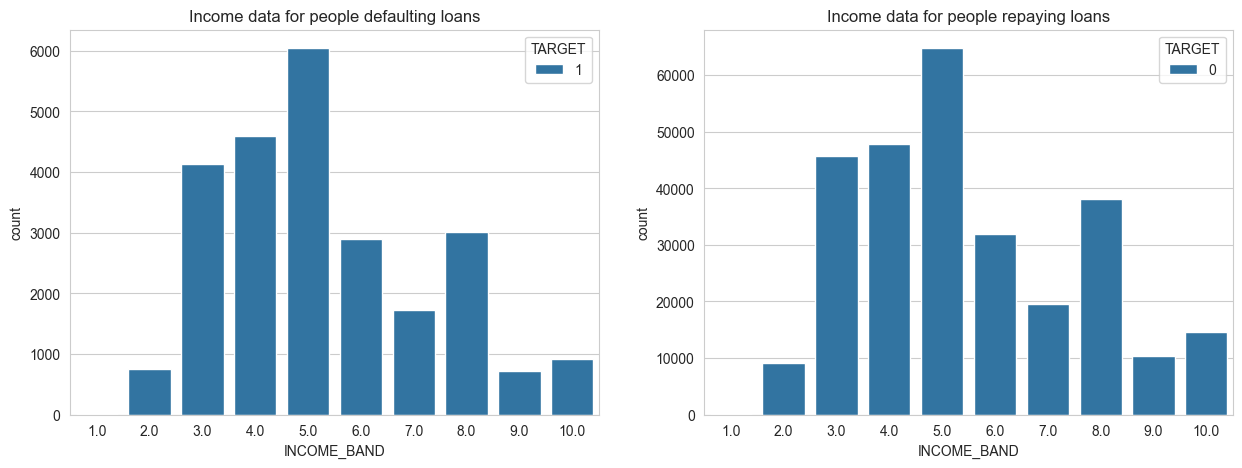

In [66]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.countplot(data=appBase[appBase.TARGET==1],x='INCOME_BAND',hue='TARGET').set_title('Income data for people defaulting loans')
plt.subplot(122)
sns.countplot(data=appBase[appBase.TARGET==0],x='INCOME_BAND',hue='TARGET').set_title('Income data for people repaying loans')
appBase.drop(columns=['INCOME_BAND'],inplace=True);

Observing the income bands for those with defaulting loans vs those with repaid loans, we do not see any major differences, but the distribution of repaid loans slightly increases for higher income bands. 

---

The exploratory data analysis can be continued bureau dataset, the feature distributions can be seen below

In [67]:
application_bureau_train = appBase.merge(bureau, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

In [68]:
print("The resulting dataframe `application_bureau_train` has ",application_bureau_train.shape[0]," rows and ", 
      application_bureau_train.shape[1]," columns.")

The resulting dataframe `application_bureau_train` has  1465325  rows and  138  columns.


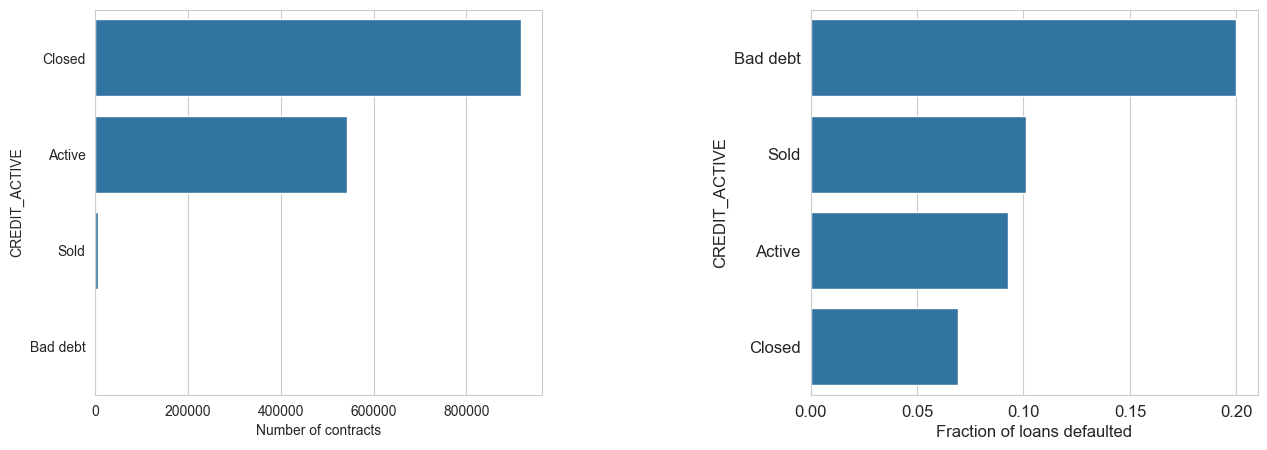

In [69]:
plot_bar_gen('CREDIT_ACTIVE',application_bureau_train)

For the feature, CREDIT_ACTIVE, we see that there are more loans taken by those without active credit and they are more defaulted by those who have bad debt or sold credit

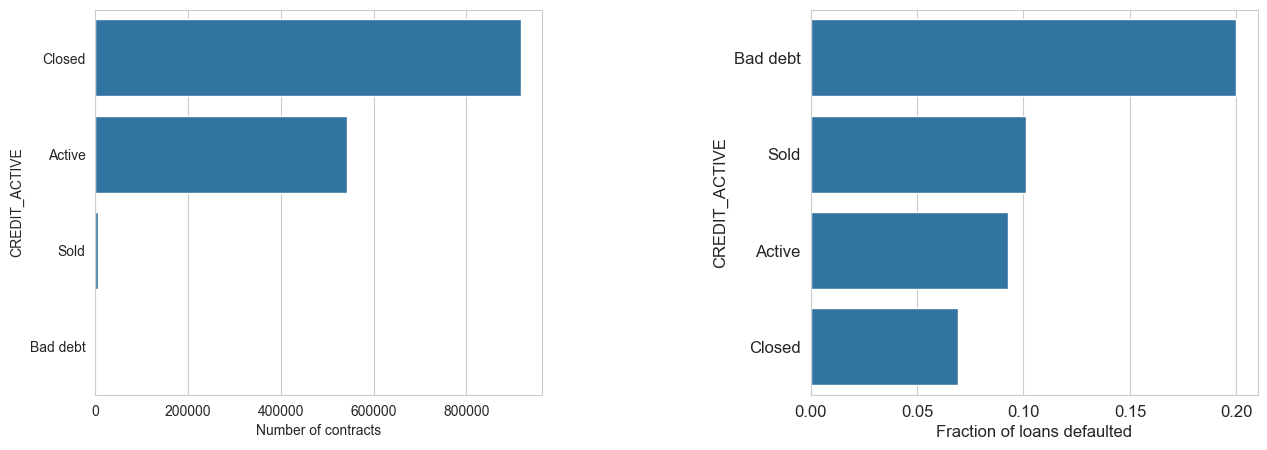

In [70]:
plot_bar_gen('CREDIT_ACTIVE',application_bureau_train)

For the feature, CREDIT_CURRENCY, we see that there are most loans taken by those using currency 1 and they are more defaulted by those who use currency 3

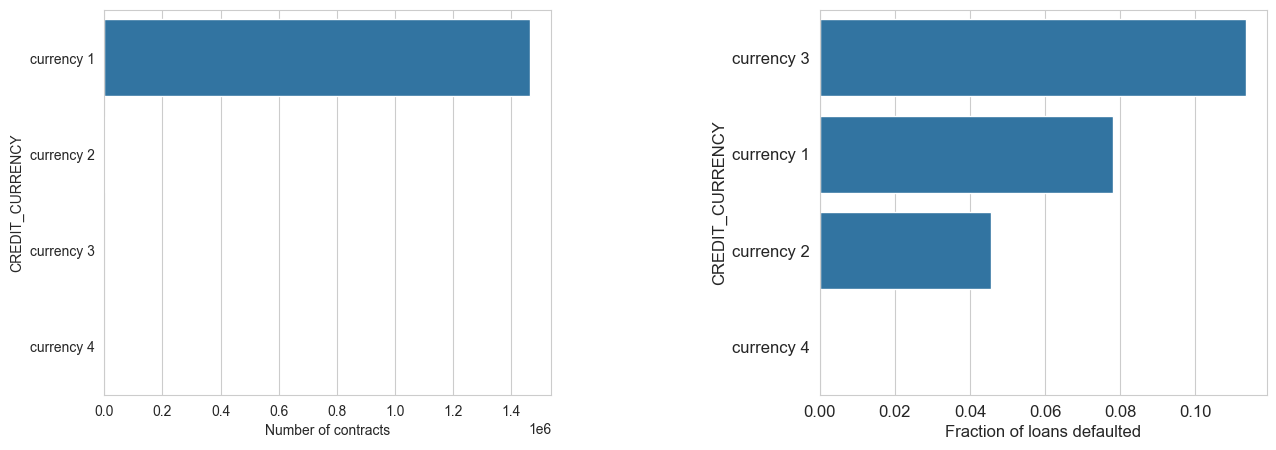

In [71]:
plot_bar_gen('CREDIT_CURRENCY',application_bureau_train)

For the feature, CREDIT_TYPE, we see that there are most loans taken by those with consumer credit/credit card and they are more defaulted by those who use loans for equipment purchase or microloans

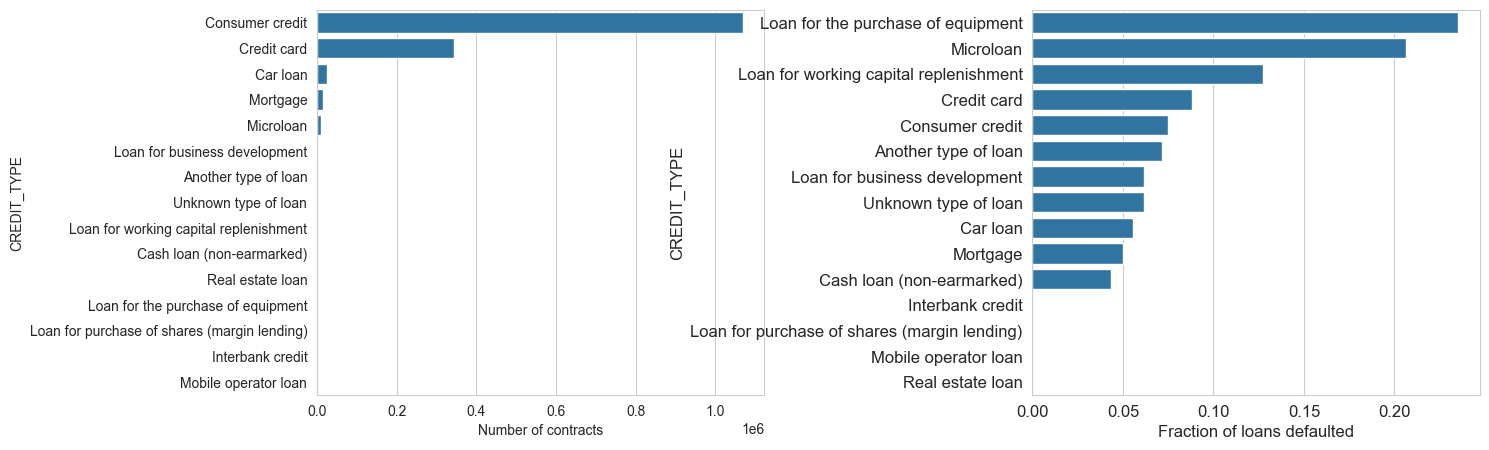

In [72]:
plot_bar_gen('CREDIT_TYPE',application_bureau_train)

---

## <b> 3.0 Feature Engineering </b>

After exploring the data distributions, we can now conduct feature engineering to prepare the features before building the classifier models

In [73]:
## Save the csv files as a checkpoint if necessary (high memory and time intensive)

save_files = False

if save_files == True:
    appBase.to_csv('application_train_updated.csv', index = False)
    bureau.to_csv('bureau_updated.csv', index = False)

In [76]:
# Load csv files from checkpoint if necessary
# Otherwise, copy to new df and clean up memory 

load_files = False  # Existing variables in memory

if load_files == False:
    application_train_new = appBase.copy()
    bureau_new = bureau.copy()
    
    
    gc.enable()
    del appBase, bureau
    gc.collect()
    
else:
    application_train_new = pd.read_csv("application_train_updated.csv")
    bureau_new = pd.read_csv("bureau_updated.csv")            

---

<b> 3.2 Basic Feature Engineering (Replacing outliers, Imputing, One-hot encoding, Rescaling data) </b> 

First, a function is created and run to replace the day outliers previously seen across the data

In [77]:
def replace_day_outliers(df):
    """Replace 365243 with np.nan in any columns with DAYS"""
    for col in df.columns:
        if "DAYS" in col:
            df[col] = df[col].replace({365243: np.nan})

    return df

In [78]:
# Replace all the day outliers
application_train_new = replace_day_outliers(application_train_new)
bureau_new = replace_day_outliers(bureau_new )    

We create a function to remove columns which have missing values greater than 60%

In [79]:
#Function for removing columns with missing values more than 60%

def remove_missing_col(df):
    miss_data = pd.DataFrame((df.isnull().sum())*100/df.shape[0])
    miss_data_col=miss_data[miss_data[0]>60].index
    data_new  = df[[i for i in df.columns if i not in miss_data_col]]
    return data_new

In [85]:
#Custom imputer for numerical and categorical variables (https://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn)

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with median of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [86]:
# one-hot encoding of categorical variables
base_case_train = pd.get_dummies(application_train_new)

In [88]:
# Drop the SK_ID from the training data
skid_temp = application_train_new['SK_ID_CURR']
train = base_case_train.drop(columns = ['SK_ID_CURR'])
    
# Feature names
features = list(train.columns)

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Median imputation of missing values
train = DataFrameImputer().fit_transform(train)

## Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
base_case_train = pd.DataFrame(data=train, columns=features)

print('Data shape: ', base_case_train.shape)

Data shape:  (307511, 245)


In [89]:
base_case_train

TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0          1.0           0.0          0.207607    0.090287     0.090032   
1          0.0           0.0          0.286846    0.311736     0.132924   
2          0.0           0.0          0.049128    0.022472     0.020025   
3          0.0           0.0          0.128368    0.066837     0.109477   
4          0.0           0.0          0.112520    0.116854     0.078975   
...        ...           ...               ...         ...          ...   
307506     0.0           0.0          0.154781    0.052360     0.101176   
307507     0.0           0.0          0.054411    0.056067     0.040505   
307508     0.0           0.0          0.149498    0.157969     0.110618   
307509     1.0           0.0          0.170629    0.081175     0.072499   
307510     0.0           0.0          0.154781    0.157303     0.185258   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  OWN_CAR_AGE  FLAG_MOBIL  \
0              0.077441                    0.256321     0.098901         1.0   
1              0.271605                    0.045016     0.098901         1.0   
2              0.023569                    0.134897     0.285714         1.0   
3              0.063973                    0.107023     0.098901         1.0   
4              0.117845                    0.392880     0.098901         1.0   
...                 ...                         ...          ...         ...   
307506         0.046016                    0.446855     0.098901         1.0   
307507         0.046016                    0.344429     0.098901         1.0   
307508         0.135802                    0.065247     0.098901         1.0   
307509         0.069585                    0.069553     0.098901         1.0   
307510         0.158249                    0.635991     0.098901         1.0   

        FLAG_EMP_PHONE  ...  HOUSETYPE_MODE_terraced house  \
0                  1.0  ...                            0.0   
1                  1.0  ...                            0.0   
2                  1.0  ...                            0.0   
3                  1.0  ...                            0.0   
4                  1.0  ...                            0.0   
...                ...  ...                            ...   
307506             1.0  ...                            0.0   
307507             0.0  ...                            0.0   
307508             1.0  ...                            0.0   
307509             1.0  ...                            0.0   
307510             1.0  ...                            0.0   

        WALLSMATERIAL_MODE_Block  WALLSMATERIAL_MODE_Mixed  \
0                            0.0                       0.0   
1                            1.0                       0.0   
2                            0.0                       0.0   
3                            0.0                       0.0   
4                            0.0                       0.0   
...                          ...                       ...   
307506                       0.0                       0.0   
307507                       0.0                       0.0   
307508                       0.0                       0.0   
307509                       0.0                       0.0   
307510                       0.0                       0.0   

        WALLSMATERIAL_MODE_Monolithic  WALLSMATERIAL_MODE_Others  \
0                                 0.0                        0.0   
1                                 0.0                        0.0   
2                                 0.0                        0.0   
3                                 0.0                        0.0   
4                                 0.0                        0.0   
...                               ...                        ...   
307506                            0.0                        0.0   
307507                            0.0                        0.0   
307508                            0.0       

In [90]:
base_case_train['SK_ID_CURR'] = skid_temp

print('Data shape: ', base_case_train.shape)

Data shape:  (307511, 246)


In [93]:
# Train-Test split -- temporary
# Logistic regression - sanity check 

#splitting application_train_newdf into train and test
train,test = train_test_split(base_case_train,test_size=.25,random_state = 123)

#separating dependent and independent variables
train_X = train[[i for i in train.columns if i not in ['SK_ID_CURR'] + [ 'TARGET']]]
train_Y = train[["TARGET"]]

test_X  = test[[i for i in test.columns if i not in ['SK_ID_CURR'] + [ 'TARGET']]]
test_Y  = test[["TARGET"]]

In [94]:
#Model function

def model_base(algorithm,dtrain_X,dtrain_Y,dtest_X,dtest_Y,cols=None):
    
    # Extract feature names
    feature_names = list(dtrain_X.columns)
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    algorithm.fit(dtrain_X[cols],dtrain_Y)
    predictions = algorithm.predict(dtest_X[cols])
    prediction_probabilities = algorithm.predict_proba(dtest_X[cols])[:,1]
    
    # Record the feature importances
    feature_importance_values= algorithm.coef_[0]
    feature_importance_values = np.absolute(feature_importance_values)
#     # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    print (algorithm)
    print ("Accuracy score : ", accuracy_score(predictions,dtest_Y))
    print ("classification report :\n",classification_report(predictions,dtest_Y))
    fpr , tpr , thresholds   = roc_curve(dtest_Y,prediction_probabilities)
    
    fig = plt.figure(figsize=(10,8))
    ax  = fig.add_subplot(111)
    ax.plot(fpr,tpr,label   = ["Area under curve : ",auc(fpr,tpr)],linewidth=2,linestyle="dotted")
    ax.plot([0,1],[0,1],linewidth=2,linestyle="dashed")
    plt.legend(loc="best")
    plt.title("ROC-CURVE & AREA UNDER CURVE")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    
    return feature_importances

LogisticRegression()
Accuracy score :  0.9184812300007804
classification report :
               precision    recall  f1-score   support

         0.0       1.00      0.92      0.96     76746
         1.0       0.01      0.51      0.02       132

    accuracy                           0.92     76878
   macro avg       0.50      0.71      0.49     76878
weighted avg       1.00      0.92      0.96     76878



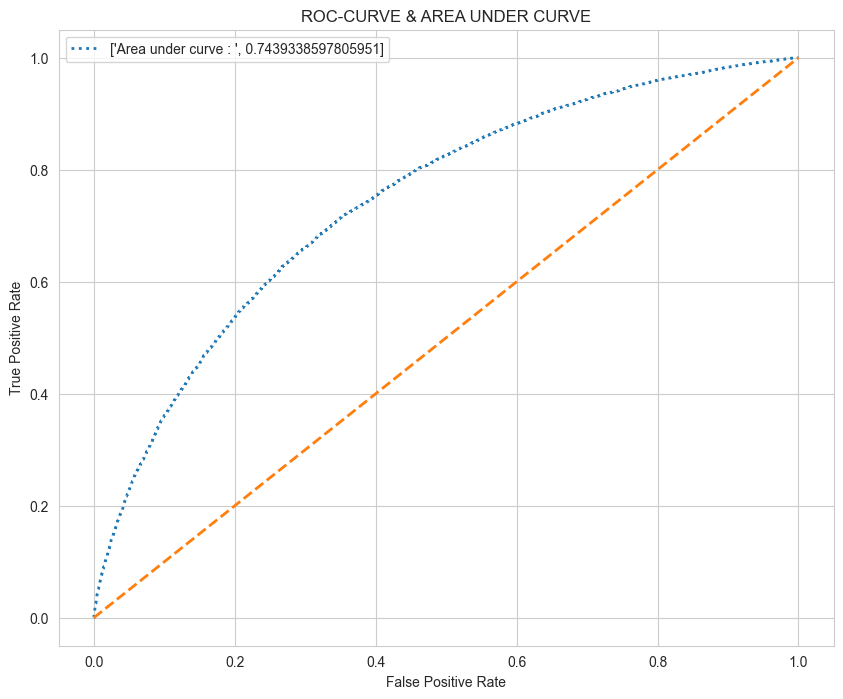

In [95]:
logit = LogisticRegression()
feature_importances_logit_base = model_base(logit,train_X,train_Y,test_X,test_Y,train_X.columns)

On running the base case - logistic regression model, we see that it does a good job of predicting the cases when loan is repaid (f1-score = 0.96) but does not perform well to predict when loans are defaulted (f1-score = 0.02). 

However, since this is an imbalanced dataset, the accuracy score is still high at 0.9184. Hence, it is preferred to use test AUC ROC which does not depend on data imbalance and has a value of 0.7454 for the base case.  

The Receiver Operating Characteristic Area under curve (ROC AUC) is a metric for which can be suitably applied for imbalanced datasets since it does not generate 0 or 1 predictions, but rather a probability between 0 and 1. It measures the false positive rate (x-axis) vs true positive rate (y-axis). The area under curve (AUC) is the area between a model's ROC curve and the diagonal indicating a model with naive random guessing. If the ROC curve is more to the left/top of the diagonal, is indicates better performance with a higher ROC AUC.

---

After training a base case, we can return to feature engineering.

First we apply our limited domain knowlege to create few more variables, specifically ratios accounting for the credit income %, annuity income %, credit term, and fraction of years employed  

In [96]:
#Domain knowledge

application_train_new['CREDIT_INCOME_PERCENT'] = application_train_new['AMT_CREDIT'] / application_train_new['AMT_INCOME_TOTAL']
application_train_new['ANNUITY_INCOME_PERCENT'] = application_train_new['AMT_ANNUITY'] / application_train_new['AMT_INCOME_TOTAL']
application_train_new['CREDIT_TERM'] = application_train_new['AMT_ANNUITY'] / application_train_new['AMT_CREDIT']
application_train_new['YEARS_EMPLOYED_PERCENT'] = application_train_new['YEARS_EMPLOYED'] / application_train_new['AGE']

In [110]:
# Iterate through the columns and record the Boolean columns

def bool_type(df):

    col_type = {}

    for col in df:
        # If column is a number with only two values, encode it as a Boolean
        if (df[col].dtype != 'object') and (len(df[col].unique()) <= 2):
            col_type[col] = ft.variable_types.Boolean

    print('Number of boolean variables: ', len(col_type))
    return col_type

In [ ]:
train_col_type = bool_type(application_train_new)

train_col_type['REGION_RATING_CLIENT'] = ft.variable_types.Ordinal
train_col_type['REGION_RATING_CLIENT_W_CITY'] = ft.variable_types.Ordinal

We start connecting the datasets using Featuretools by first creating an entity and then adding the datasets while connected by a common index (SK_ID_CURR). For other datasets, indexes are created as necessary 

In [ ]:
# Entity set with id applications
es = ft.EntitySet(id = 'clients')

In [ ]:
# Entities with a unique index
es = es.entity_from_dataframe(entity_id = 'app', dataframe = application_train_new, index = 'SK_ID_CURR', variable_types = train_col_type)

es = es.entity_from_dataframe(entity_id = 'bureau', dataframe = bureau_new, index = 'SK_ID_BUREAU')

In [ ]:
# Relationship between app and bureau
r_app_bureau = ft.Relationship(es['app']['SK_ID_CURR'], es['bureau']['SK_ID_CURR'])

The individual relationships are pooled together and the entity set is shown for inspection 

In [ ]:
# Add in the defined relationships
es = es.add_relationships([r_app_bureau])
# Print out the EntitySet
es

[Feature primitives](https://docs.featuretools.com/automated_feature_engineering/primitives.html) are operations conducted on tables to create a feature. The two common types are aggregation and transformation.

An Aggregation groups together values from child dataset for each parent and then calculates a feature such as mean, min, max, or standard deviation. A transformation can be applied to one or more columns in a single table such as the difference between two columns or the absolute value of one. Some common primitives in featuretools are shown below

In [ ]:
# List the primitives in a dataframe
primitives = ft.list_primitives()
pd.options.display.max_colwidth = 100
primitives[primitives['type'] == 'aggregation'].head(10)

name         type  dask_compatible  \
0          entropy  aggregation            False   
1              min  aggregation             True   
2  time_since_last  aggregation            False   
3             mean  aggregation             True   
4              any  aggregation             True   
5            count  aggregation             True   
6             last  aggregation            False   
7           median  aggregation            False   
8            trend  aggregation            False   
9    n_most_common  aggregation            False   

                                                                 description  
0                          Calculates the entropy for a categorical variable  
1                      Calculates the smallest value, ignoring `NaN` values.  
2  Calculates the time elapsed since the last datetime (default in seconds).  
3                                 Computes the average for a list of values.  
4                               Determines if any value is 'True' in a list.  
5                    Determines the total number of values, excluding `NaN`.  
6                                       Determines the last value in a list.  
7                      Determines the middlemost number in a list of values.  
8                              Calculates the trend of a variable over time.  
9                                   Determines the `n` most common elements.

In [ ]:
primitives[primitives['type'] == 'transform'].head(10)

name       type  dask_compatible  \
22                           negate  transform             True   
23                        num_words  transform             True   
24                          cum_sum  transform            False   
25  scalar_subtract_numeric_feature  transform             True   
26                             diff  transform            False   
27                        longitude  transform            False   
28                          weekday  transform             True   
29                               or  transform             True   
30                divide_by_feature  transform             True   
31                        haversine  transform            False   

                                                           description  
22                                            Negates a numeric value.  
23  Determines the number of words in a string by counting the spaces.  
24                                      Calculates the cumulative sum.  
25                Subtract each value in the list from a given scalar.  
26          Compute the difference between the value in a list and the  
27         Returns the second tuple value in a list of LatLong tuples.  
28                     Determines the day of the week from a datetime.  
29                               Element-wise logical OR of two lists.  
30                          Divide a scalar by each value in the list.  
31   Calculates the approximate haversine distance between two LatLong

A few default primitives are selected for Deep Feature Synthesis (DFS), which is the process featuretools uses to make new features. The depth is the number of primitives that are stacked together to form new features. Initially, we only see the number of features by using features_only = TRUE which creates the feature combinations but does not actually do the calculations for the data.

In [ ]:
# Default primitives from featuretools
default_agg_primitives =  ['sum', 'count', 'min', 'max', 'mean', 'mode']
default_trans_primitives =  ['diff', 'cum_sum', 'cum_mean', 'percentile']

# DFS with specified primitives
feature_names = ft.dfs(entityset = es, target_entity = 'app',
                       trans_primitives = default_trans_primitives,
                       agg_primitives=default_agg_primitives, 
                       max_depth = 2, features_only=True)

print('%d Total Features' % len(feature_names))

3534 Total Features


We see that 3534 features are expected to be created from the DFS process. Moving forward, we can create the features and display the created features for inspection

In [ ]:
# DFS with default primitives

feature_matrix, feature_names = ft.dfs(entityset = es, target_entity = 'app',
                                       trans_primitives = default_trans_primitives,
                                       agg_primitives=default_agg_primitives, 
                                        max_depth = 2, features_only=False, verbose = True)

pd.options.display.max_columns = 1500
feature_matrix.head(10)

Built 3534 features
Elapsed: 54:58 | Progress: 100%|██████████


NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
SK_ID_CURR                                                               
100002             Cash loans           M            N               Y   
100003             Cash loans           F            N               N   
100004        Revolving loans           M            Y               Y   
100006             Cash loans           F            N               Y   
100007             Cash loans           M            N               Y   
100008             Cash loans           M            N               Y   
100009             Cash loans           F            Y               Y   
100010             Cash loans           M            Y               Y   
100011             Cash loans           F            N               Y   
100012        Revolving loans           M            N               Y   

            CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                                            
100002                 0          202500.0    406597.5      24700.5   
100003                 0          270000.0   1293502.5      35698.5   
100004                 0           67500.0    135000.0       6750.0   
100006                 0          135000.0    312682.5      29686.5   
100007                 0          121500.0    513000.0      21865.5   
100008                 0           99000.0    490495.5      27517.5   
100009                 1          171000.0   1560726.0      41301.0   
100010                 0          360000.0   1530000.0      42075.0   
100011                 0          112500.0   1019610.0      33826.5   
100012                 0          135000.0    405000.0      20250.0   

            AMT_GOODS_PRICE  NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
SK_ID_CURR                                                           
100002             351000.0    Unaccompanied               Working   
100003            1129500.0           Family         State servant   
100004             135000.0    Unaccompanied               Working   
100006             297000.0    Unaccompanied               Working   
100007             513000.0    Unaccompanied               Working   
100008             454500.0  Spouse, partner         State servant   
100009            1395000.0    Unaccompanied  Commercial associate   
100010            1530000.0    Unaccompanied         State servant   
100011             913500.0         Children             Pensioner   
100012             405000.0    Unaccompanied               Working   

                      NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
SK_ID_CURR                                                        
100002      Secondary / secondary special  Single / not married   
100003                   Higher education               Married   
100004      Secondary / secondary special  Single / not married   
100006      Secondary / secondary special        Civil marriage   
100007      Secondary / secondary special  Single / not married   
100008      Secondary / secondary special               Married   
100009                   Higher education               Married   
100010                   Higher education               Married   
100011      Secondary / secondary special               Married   
100012      Secondary / secondary special  Single / not married   

            NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  OWN_CAR_AGE  \
SK_ID_CURR                                                               
100002      House / apartment                    0.018801          NaN   
100003      House / apartment                    0.003541          NaN   
100004      House / apartment                    0.010032         26.0   
100006      House / apartment                    0.008019          NaN   
100007      House / apartment                    0.028663          NaN   
100008      House / apartment                    0.035792          NaN   
100009      House / apartment  

In the above table, we see that there are a number of different features created, including a number of categorical ones. Moreover, many features have high missing values and other may have a high degree of correlations with each other. Such issues need to be accounted for before training models.

---

<b> 3.5 Return to manual feature engineering </b>

First, we remove the features having more than 60% missing values from the newly constructed dataset

In [ ]:
#Removing columns with missing values more than 60% in new df

feature_matrix = remove_missing_col(feature_matrix)

Then, we separate the reponse feature (TARGET) temporarily before conducting other operations 

In [ ]:
#Separate TARGET feature temporarily 
target_temp = feature_matrix['TARGET']
feature_matrix = feature_matrix.drop(columns = ['TARGET'])

The categorical variables are one-hot encoded

In [ ]:
# one-hot encoding of categorical variables
feature_matrix = pd.get_dummies(feature_matrix)

The features with low information (only 1 unique value) are removed

In [ ]:
# Remove features with only one unique value
feature_matrix2 = selection.remove_low_information_features(feature_matrix)

print('Removed %d features' % (feature_matrix.shape[1]- feature_matrix2.shape[1]))

Removed 6 features


We can see that the one-hot encoding has increased the columns even if the other operations reduced them.

In [ ]:
feature_matrix2.head()

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                                            
100002                 0          202500.0    406597.5      24700.5   
100003                 0          270000.0   1293502.5      35698.5   
100004                 0           67500.0    135000.0       6750.0   
100006                 0          135000.0    312682.5      29686.5   
100007                 0          121500.0    513000.0      21865.5   

            AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  CNT_FAM_MEMBERS  \
SK_ID_CURR                                                                 
100002             351000.0                    0.018801              1.0   
100003            1129500.0                    0.003541              2.0   
100004             135000.0                    0.010032              1.0   
100006             297000.0                    0.008019              2.0   
100007             513000.0                    0.028663              1.0   

            HOUR_APPR_PROCESS_START  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  \
SK_ID_CURR                                                                      
100002                           10      0.083037      0.262949      0.139376   
100003                           11      0.311267      0.622246           NaN   
100004                            9           NaN      0.555912      0.729567   
100006                           17           NaN      0.650442           NaN   
100007                           11           NaN      0.322738           NaN   

            APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  \
SK_ID_CURR                                                                  
100002              0.0247            0.0369                       0.9722   
100003              0.0959            0.0529                       0.9851   
100004                 NaN               NaN                          NaN   
100006                 NaN               NaN                          NaN   
100007                 NaN               NaN                          NaN   

            ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  LANDAREA_AVG  \
SK_ID_CURR                                                              
100002               0.00         0.0690         0.0833        0.0369   
100003               0.08         0.0345         0.2917        0.0130   
100004                NaN            NaN            NaN           NaN   
100006                NaN            NaN            NaN           NaN   
100007                NaN            NaN            NaN           NaN   

            LIVINGAREA_AVG  NONLIVINGAREA_AVG  APARTMENTS_MODE  \
SK_ID_CURR                                                       
100002              0.0190             0.0000           0.0252   
100003              0.0549             0.0098           0.0924   
100004                 NaN                NaN              NaN   
100006                 NaN                NaN              NaN   
100007                 NaN                NaN              NaN   

            BASEMENTAREA_MODE  YEARS_BEGINEXPLUATATION_MODE  ELEVATORS_MODE  \
SK_ID_CURR                                                                    
100002                 0.0383                        0.9722          0.0000   
100003                 0.0538                        0.9851          0.0806   
100004                    NaN                           NaN             NaN   
100006                    NaN                           NaN             NaN   
100007                    NaN                           NaN             NaN   

            ENTRANCES_MODE  FLOORSMAX_MODE  LANDAREA_MODE  LIVINGAREA_MODE  \
SK_ID_CURR                                                                   
100002              0.0690          0.0833         0.0377           0.0198   
100003              0.0345          0.2917         0.0128           0.0554   
100004                 NaN      

Since there are almost 3000 features (columns), it is important to account for correlated features which do not add unique information but contribute to the curse of dimensionality. Hence, we can create a correlation matrix to find the correlated features and remove one feature from each correlation pair which is larger than a given threshold (0.8).  

In [ ]:
feature_matrix=feature_matrix2.copy()

In [ ]:
# Threshold for removing correlated variables (without TARGET)
threshold = 0.8

# Calculate absolute value correlation matrix
corr_matrix = feature_matrix.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Select columns with correlations above threshold
collinear_features = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d features to remove.' % (len(collinear_features)))

There are 1923 features to remove.


In [ ]:
#Remove collinear features
feature_matrix = feature_matrix[[col for col in feature_matrix.columns if col not in collinear_features]] 

Thus, 1923 correlated features are removed from the dataset and the response feature (TARGET) is reattached.

In [ ]:
feature_matrix['TARGET'] = target_temp

The table below shows the dataset at this stage, and we can see that there are still a number of NaN values and features that require scaling.

In [ ]:
feature_matrix.head()

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                                            
100002                 0          202500.0    406597.5      24700.5   
100003                 0          270000.0   1293502.5      35698.5   
100004                 0           67500.0    135000.0       6750.0   
100006                 0          135000.0    312682.5      29686.5   
100007                 0          121500.0    513000.0      21865.5   

            REGION_POPULATION_RELATIVE  HOUR_APPR_PROCESS_START  EXT_SOURCE_1  \
SK_ID_CURR                                                                      
100002                        0.018801                       10      0.083037   
100003                        0.003541                       11      0.311267   
100004                        0.010032                        9           NaN   
100006                        0.008019                       17           NaN   
100007                        0.028663                       11           NaN   

            EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
SK_ID_CURR                                                                 
100002          0.262949      0.139376          0.0247            0.0369   
100003          0.622246           NaN          0.0959            0.0529   
100004          0.555912      0.729567             NaN               NaN   
100006          0.650442           NaN             NaN               NaN   
100007          0.322738           NaN             NaN               NaN   

            YEARS_BEGINEXPLUATATION_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  \
SK_ID_CURR                                                              
100002                           0.9722         0.0690         0.0833   
100003                           0.9851         0.0345         0.2917   
100004                              NaN            NaN            NaN   
100006                              NaN            NaN            NaN   
100007                              NaN            NaN            NaN   

            LANDAREA_AVG  NONLIVINGAREA_AVG  OBS_30_CNT_SOCIAL_CIRCLE  \
SK_ID_CURR                                                              
100002            0.0369             0.0000                       2.0   
100003            0.0130             0.0098                       1.0   
100004               NaN                NaN                       0.0   
100006               NaN                NaN                       2.0   
100007               NaN                NaN                       0.0   

            DEF_30_CNT_SOCIAL_CIRCLE  DAYS_LAST_PHONE_CHANGE  \
SK_ID_CURR                                                     
100002                           2.0                 -1134.0   
100003                           0.0                  -828.0   
100004                           0.0                  -815.0   
100006                           0.0                  -617.0   
100007                           0.0                 -1106.0   

            AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
SK_ID_CURR                                                          
100002                             0.0                        0.0   
100003                             0.0                        0.0   
100004                             0.0                        0.0   
100006                             NaN                        NaN   
100007                             0.0                        0.0   

            AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
SK_ID_CURR                                                          
100002                             0.0                        0.0   
100003                             0.0                        0.0   
100004                             0.0                        0.0   
100006                             NaN                        NaN   
100007                             0.0    

Hence, imputation of missing values is done, followed by scaling to make the dataset ready for modeling.

In [ ]:
# Feature names
features = list(feature_matrix.columns)

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Median imputation of missing values
train = DataFrameImputer().fit_transform(feature_matrix)
train.replace([np.inf, -np.inf], np.nan, inplace=True)
train.fillna(feature_matrix.median(), inplace=True)

## Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
feature_matrix = pd.DataFrame(data=train, columns=features)

The dataset is finally ready for training. However, before that we can save it as a checkpoint or load it from this checkpoint

In [ ]:
#save dataset

feature_matrix.to_csv('feature_matrix.csv')

#load dataset

#feature_matrix= pd.read_csv("feature_matrix.csv")

---

### <b> 4.0 Classifier Models: Training, Prediction </b> 

Now that we have created the final dataset, we can start building the classifier models.

---

<b> 4.1 Data split and imbalance correction </b>

First, we split the data into training/testing set in the ratio 75:25

In [ ]:
#splitting application_train_newdf into train and test
train,test = train_test_split(feature_matrix,test_size=.25,random_state = 123)

#separating dependent and independent variables (no under/over sampling)
train_X = train[[i for i in train.columns if i not in ['SK_ID_CURR'] + [ 'TARGET']]]
train_Y = train[["TARGET"]]

test_X  = test[[i for i in test.columns if i not in ['SK_ID_CURR'] + [ 'TARGET']]]
test_Y  = test[["TARGET"]]

Since the dataset is imbalanced in the favor of majority samples being where the loans are repaid (TARGET=1) in a ratio more than 10:1, we can resample the data, by undersampling the majority class to make the data more balanced. So that we do not lose too much valuable data, the number of majority class samples is kept as twice the number of minority class.  

In [ ]:
# Down-sample Majority Class

count = train['TARGET'].value_counts()
num_majority = count[0]
num_minority = count[1]

#Number of undersampled majority class 2 x minority class
num_undersample_majority = 2 * num_minority

#separating majority and minority classes
df_majority = train[train["TARGET"] == 0]
df_minority = train[train["TARGET"] == 1]

df_majority_undersampled = resample(df_majority, replace=False,
                                   n_samples=num_undersample_majority,
                                   random_state=123)

df_undersampled = pd.concat([df_minority,df_majority_undersampled],axis=0)

#splitting dependent and independent variables

df_undersampled_X = df_undersampled[[i for i in df_undersampled.columns if i not in ['SK_ID_CURR'] + [ 'TARGET']]]
df_undersampled_Y = df_undersampled[["TARGET"]]

---

<b> 4.2 Training classifier models </b>

First, we create a function for the classifier to train on data, predict using test data, and visualize the metrics

In [ ]:
#Model function

def model_run(algorithm,dtrain_X,dtrain_Y,dtest_X,dtest_Y,cols=None):

    algorithm.fit(dtrain_X[cols],dtrain_Y)
    predictions = algorithm.predict(dtest_X[cols])
    prediction_probabilities = algorithm.predict_proba(dtest_X[cols])[:,1]
    
    accuracy = accuracy_score(dtest_Y,predictions)
    classify_metrics = classification_report(dtest_Y,predictions)
    f1=f1_score(dtest_Y,predictions)
    
    fpr , tpr , thresholds   = roc_curve(dtest_Y,prediction_probabilities)
    auc_score = auc(fpr,tpr)
    
    print (algorithm)
    print ("Accuracy score : ", accuracy)
    print ("F1 score : ", f1)
    print ("AUC : ", auc_score)
    print ("classification report :\n", classify_metrics)
    
    return accuracy, classify_metrics, fpr , tpr, auc_score, f1

***Model 1: Logistic Regression***

In [ ]:
logit = LogisticRegression()
accuracy_logit, classify_metrics_logit, fpr_logit , tpr_logit, auc_score_logit, f1_logit = model_run(logit,df_undersampled_X ,df_undersampled_Y ,test_X,test_Y,train_X.columns)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Accuracy score :  0.9184552147558469
F1 score :  0.0
AUC :  0.5079506310277306
classification report :
               precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     70609
         1.0       0.00      0.00      0.00      6269

   micro avg       0.92      0.92      0.92     76878
   macro avg       0.46      0.50      0.48     76878
weighted avg       0.84      0.92      0.88     76878



***Model 2: Random Forest Classifier***

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
accuracy_rfc, classify_metrics_rfc, fpr_rfc , tpr_rfc, auc_score_rfc, f1_rfc = model_run(rfc,df_undersampled_X ,df_undersampled_Y ,test_X,test_Y,train_X.columns)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy score :  0.8451442545331564
F1 score :  0.2208259702860135
AUC :  0.6670330068110739
classification report :
               precision    recall  f1-score   support

         0.0       0.93      0.90      0.91     70609
         1.0       0.19      0.27      0.22      6269

   micro avg       0.85      0.85      0.85     76878
   macro avg       0.56      0.58      0.57     76878
weighted avg       0.87      0.85      0.86     76878



***Model 3: Decision Tree Classifier***

In [ ]:
dtc = DecisionTreeClassifier()
accuracy_dtc, classify_metrics_dtc, fpr_dtc , tpr_dtc, auc_score_dtc, f1_dtc = model_run(dtc,df_undersampled_X ,df_undersampled_Y ,test_X,test_Y,train_X.columns)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Accuracy score :  0.6879731522672285
F1 score :  0.19123398516520568
AUC :  0.5806372759711382
classification report :
               precision    recall  f1-score   support

         0.0       0.94      0.71      0.81     70609
         1.0       0.12      0.45      0.19      6269

   micro avg       0.69      0.69      0.69     76878
   macro avg       0.53      0.58      0.50     76878
weighted avg       0.87      0.69      0.76     76878



***Model 4: Gaussian Naive Bayes Classifier***

In [ ]:
gnb = GaussianNB()
accuracy_gnb, classify_metrics_gnb, fpr_gnb , tpr_gnb, auc_score_gnb, f1_gnb = model_run(gnb,df_undersampled_X ,df_undersampled_Y ,test_X,test_Y,train_X.columns)

GaussianNB(priors=None, var_smoothing=1e-09)
Accuracy score :  0.9184552147558469
F1 score :  0.0
AUC :  0.6691760671741791
classification report :
               precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     70609
         1.0       0.00      0.00      0.00      6269

   micro avg       0.92      0.92      0.92     76878
   macro avg       0.46      0.50      0.48     76878
weighted avg       0.84      0.92      0.88     76878



***Model 5: XGBoost Classifier***

In [ ]:
xgb = XGBClassifier()
accuracy_xgb, classify_metrics_xgb, fpr_xgb, tpr_xgb, auc_score_xgb, f1_xgb = model_run(xgb,df_undersampled_X ,df_undersampled_Y ,test_X,test_Y,train_X.columns)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)
Accuracy score :  0.8292099170113687
F1 score :  0.31039915966386555
AUC :  0.7604664679914915
classification report :
               precision    recall  f1-score   support

         0.0       0.95      0.86      0.90     70609
         1.0       0.23      0.47      0.31      6269

   micro avg       0.83      0.83      0.83     76878
   macro avg       0.59      0.67      0.61     76878
weighted avg       0.89      0.83      

***Model 6: Gradient Boosting Classifier***

In [ ]:
gbc = GradientBoostingClassifier()
accuracy_gbc, classify_metrics_gbc, fpr_gbc, tpr_gbc, auc_score_gbc, f1_gbc = model_run(gbc,df_undersampled_X ,df_undersampled_Y ,test_X,test_Y,train_X.columns)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Accuracy score :  0.8548869637607638
F1 score :  0.322153360068052
AUC :  0.7735697291504344
classification report :
               precision    recall  f1-score   support

         0.0       0.95      0.89      0.92     70609
         1.0       0.26      0.42      0.32      6269

   micro avg       0.85      0.85      0.85     76878
   macro avg       0.60      0.66      0.62     76878
weighted avg       0.89      0.85      0.87     76878



***Model 7: LightGBM Classifier***

In [ ]:
model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)

#Split into training and evaluation sets
x_train, x_eval, y_train, y_eval = train_test_split(df_undersampled_X, df_undersampled_Y, test_size=0.2, random_state=42)

#Remove possible JSON characters
x_train = x_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
x_eval = x_eval.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y_train = y_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y_eval = y_eval.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# Train the model
model.fit(x_train, y_train, eval_set = [(x_eval, y_eval)], eval_names =['valid'], eval_metric ='auc', early_stopping_rounds=200);

# prediction
predictions = model.predict(test_X);
prediction_probabilities = model.predict_proba(test_X)[:,1];

# metrics
accuracy_lgbc = accuracy_score(test_Y,predictions)
classify_metrics_lgbc = classification_report(test_Y,predictions)  
fpr_lgbc , tpr_lgbc , thresholds   = roc_curve(test_Y,prediction_probabilities)
auc_score_lgbc = auc(fpr_lgbc,tpr_lgbc)
f1_lgbc=f1_score(test_Y,predictions)

[1]	valid's auc: 0.715445	valid's binary_logloss: 0.685902
Training until validation scores don't improve for 200 rounds
[2]	valid's auc: 0.71895	valid's binary_logloss: 0.679409
[3]	valid's auc: 0.722045	valid's binary_logloss: 0.673478
[4]	valid's auc: 0.723532	valid's binary_logloss: 0.668075
[5]	valid's auc: 0.725786	valid's binary_logloss: 0.663056
[6]	valid's auc: 0.7275	valid's binary_logloss: 0.658418
[7]	valid's auc: 0.728184	valid's binary_logloss: 0.654297
[8]	valid's auc: 0.730056	valid's binary_logloss: 0.650259
[9]	valid's auc: 0.730343	valid's binary_logloss: 0.646679
[10]	valid's auc: 0.732999	valid's binary_logloss: 0.64297
[11]	valid's auc: 0.733512	valid's binary_logloss: 0.639948
[12]	valid's auc: 0.734643	valid's binary_logloss: 0.637076
[13]	valid's auc: 0.736007	valid's binary_logloss: 0.634199
[14]	valid's auc: 0.736928	valid's binary_logloss: 0.631619
[15]	valid's auc: 0.737709	valid's binary_logloss: 0.629205
[16]	valid's auc: 0.738126	valid's binary_logloss: 

In [ ]:
print ("Accuracy score : ", accuracy_lgbc)
print ("F1 score : ", f1_lgbc)
print ("AUC : ", auc_score_lgbc)
print ("classification report :\n", classify_metrics_lgbc)

Accuracy score :  0.7264366919014542
F1 score :  0.29290925595938544
AUC :  0.7806255189947043
classification report :
               precision    recall  f1-score   support

         0.0       0.96      0.73      0.83     70609
         1.0       0.19      0.69      0.29      6269

   micro avg       0.73      0.73      0.73     76878
   macro avg       0.57      0.71      0.56     76878
weighted avg       0.90      0.73      0.79     76878



<b> 4.3 Classifier model comparison </b>

After training the different classifier models, we can compare their performance on the test data using metrics like accuracy, F1-score and ROC AUC with functions given below. 

In [ ]:
# Combine results together and compare stats for all

classifier_names =['Logistic Regression','Random Forest','Decision Tree','Gaussian Naive Bayes','XGBoost','Gradient Boosting','LightGBM']
accuracy_scores = [accuracy_logit, accuracy_rfc, accuracy_dtc, accuracy_gnb, accuracy_xgb, accuracy_gbc, accuracy_lgbc] 
f1_scores = [f1_logit, f1_rfc, f1_dtc, f1_gnb, f1_xgb, f1_gbc, f1_lgbc]
auc_scores = [auc_score_logit, auc_score_rfc, auc_score_dtc, auc_score_gnb, auc_score_xgb, auc_score_gbc, auc_score_lgbc]

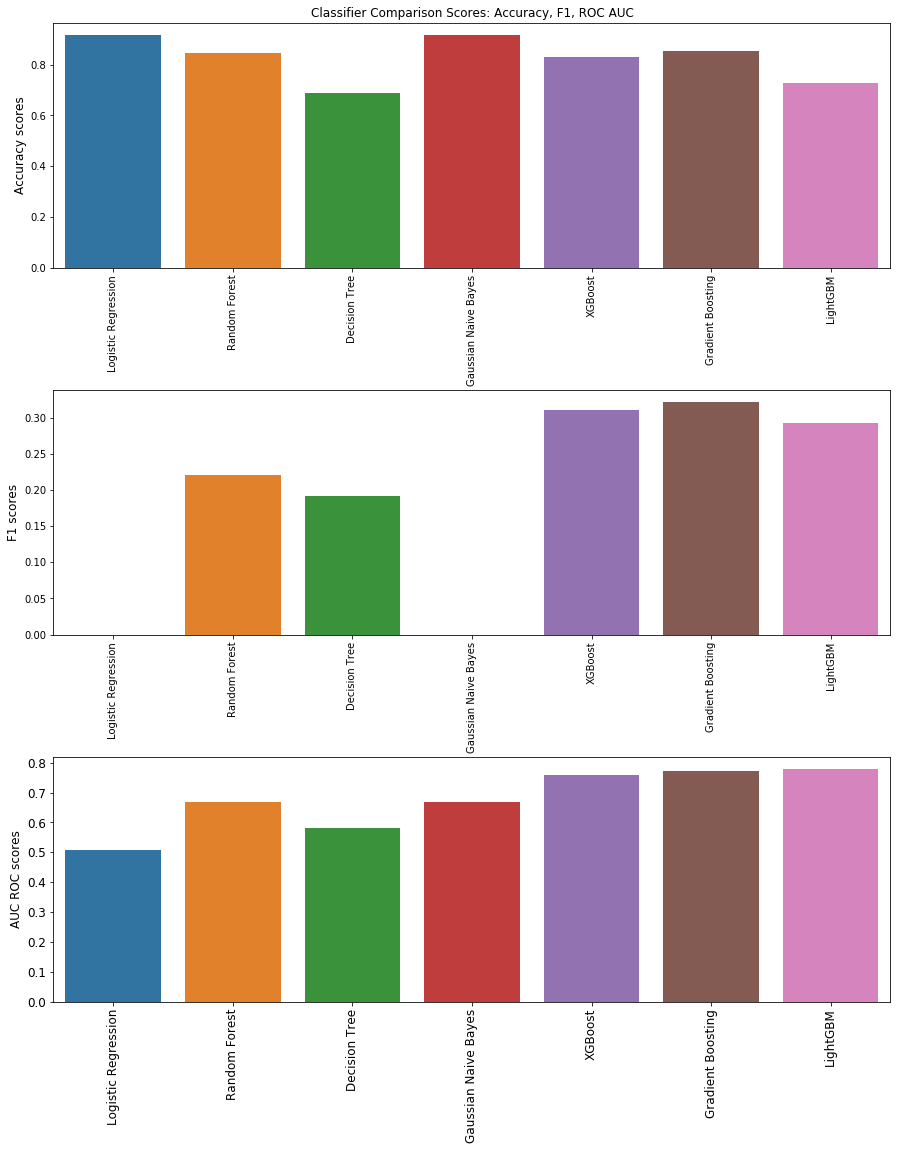

In [ ]:
sns.set_color_codes("colorblind")
    
plt.figure(figsize=(15,18))
plt.subplot(311)
plt.title('Classifier Comparison Scores: Accuracy, F1, ROC AUC')
s1 = sns.barplot(x = classifier_names, y=accuracy_scores)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
#s1.ylabel('accuracy scores', fontsize=12)
plt.ylabel('Accuracy scores', fontsize=12)
plt.subplot(312)
s2 = sns.barplot(x = classifier_names, y=f1_scores)
s2.set_xticklabels(s2.get_xticklabels(),rotation=90)
#s2.ylabel('F1 scores', fontsize=12)
plt.ylabel('F1 scores', fontsize=12)
plt.subplot(313)
s3 = sns.barplot(x = classifier_names, y=auc_scores)
s3.set_xticklabels(s3.get_xticklabels(),rotation=90)
plt.ylabel('AUC ROC scores', fontsize=12)
   
plt.tick_params(axis='both', which='major', labelsize=12)
plt.subplots_adjust(hspace = 0.5)
plt.show();

We can see from the comparisons of accuracy, F1 score and AUC ROC scores that all models have different rankings. The Logistic Regression and Gaussian Naive Bayes models have highest accuracy, but the lowest F1 scores. This shows that they do not work well for imbalanced data. The XGBoost, Gradient Boosting and LightGBM classifiers give good F1 and AUC ROC results. The AUC ROC scores can be better visualized using the ROC curves. 

Text(0, 0.5, 'True Positive Rate')

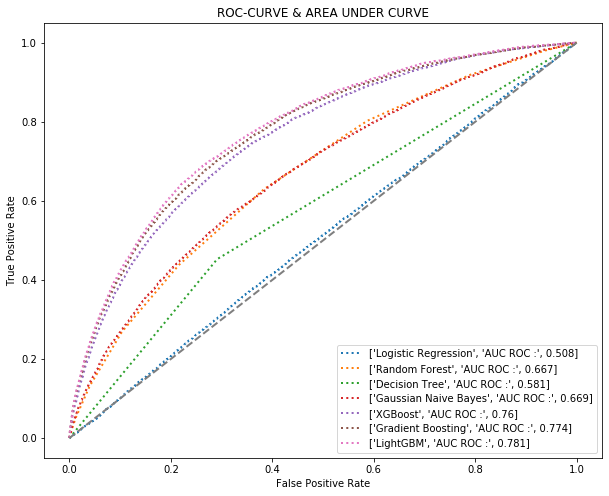

In [ ]:
fig = plt.figure(figsize=(10,8))
ax  = fig.add_subplot(111)
    
ax.plot(fpr_logit,tpr_logit,label = [classifier_names[0], "AUC ROC :", round(auc_score_logit,3)],linewidth=2,linestyle="dotted")
ax.plot(fpr_rfc,tpr_rfc,label = [classifier_names[1], "AUC ROC :", round(auc_score_rfc,3)],linewidth=2,linestyle="dotted")
ax.plot(fpr_dtc,tpr_dtc,label = [classifier_names[2], "AUC ROC :", round(auc_score_dtc,3)],linewidth=2,linestyle="dotted")
ax.plot(fpr_gnb,tpr_gnb,label = [classifier_names[3], "AUC ROC :", round(auc_score_gnb,3)],linewidth=2,linestyle="dotted")
ax.plot(fpr_xgb,tpr_xgb,label = [classifier_names[4], "AUC ROC :", round(auc_score_xgb,3)],linewidth=2,linestyle="dotted")
ax.plot(fpr_gbc,tpr_gbc,label = [classifier_names[5], "AUC ROC :", round(auc_score_gbc,3)],linewidth=2,linestyle="dotted")
ax.plot(fpr_lgbc,tpr_lgbc,label = [classifier_names[6], "AUC ROC :", round(auc_score_lgbc,3)],linewidth=2,linestyle="dotted")

ax.plot([0,1],[0,1],linewidth=2,linestyle="dashed")
plt.legend(loc="best")
plt.title("ROC-CURVE & AREA UNDER CURVE")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

The AUC ROC scores improve as the curves rise higher above the diagonal. Since, the LightGBM classifier has the best score for AUC ROC (0.781), we can choose it while moving forward.


---

<b> 4.4 K-Fold Cross validation to improve model </b>

After choosing the classifier, we can use K-fold cross validation to train multiple iterations of the model by subsampling the validation data from the training dataset during different folds. This will help us choose parameters that correspond to the best performance without creating a separate validation dataset.  

In [ ]:
def model_classify(model_in, dtrain_X, dtrain_Y, dtest_X, dtest_Y, n_folds = 5):
    
    """Train and test a model using cross validation. 
    """
       
    # Extract the ids
    train_ids = dtrain_X.index
    test_ids = dtest_X.index
    
    print('Training Data Shape: ', dtrain_X.shape)
    print('Testing Data Shape: ', dtest_X.shape)
    
    # Extract feature names
    feature_names = list(dtrain_X.columns)
    
    # Convert to np arrays
    features = np.array(dtrain_X)
    test_features = np.array(dtest_X)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    predictions = np.zeros(test_features.shape[0])
    predictions_class = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # print model
    
    print (model_in)
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], dtrain_Y.iloc[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], dtrain_Y.iloc[valid_indices]
        
        model = model_in
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'],
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions    
        predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
             
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del train_features, valid_features
        gc.collect()
        
    # Make the predictions dataframe
    test_predictions = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(dtrain_Y, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    
    # Dataframe of validation scores
    fold_scores = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    predictions_class = model.predict(test_features, num_iteration = best_iteration)

    
    fpr , tpr , thresholds   = roc_curve(dtest_Y,predictions)
    auc_roc = auc(fpr,tpr)
    f1_sc = f1_score(dtest_Y,predictions_class)
    accuracy = accuracy_score(dtest_Y,predictions_class)
    classify_metrics = classification_report(dtest_Y,predictions_class)
       
    print (model)
    
    return feature_importances, classify_metrics, fold_scores, accuracy, f1_sc, auc_roc, fpr, tpr 

The LightGBM classifier is trained with 5 folds to see which iteration gives the best ROC AUC scores

In [ ]:
model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)

feature_importances, classify_metrics, fold_scores, accuracy, f1_sc, auc_score, fpr, tpr  = model_classify(model, df_undersampled_X, df_undersampled_Y, test_X, test_Y)

print('Baseline metrics')
print(fold_scores)

Training Data Shape:  (55668, 2992)
Testing Data Shape:  (76878, 2992)
LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.05,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=10000, n_jobs=-1, num_leaves=31,
        objective='binary', random_state=50, reg_alpha=0.1, reg_lambda=0.1,
        silent=True, subsample=0.8, subsample_for_bin=200000,
        subsample_freq=0)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.872391	train's binary_logloss: 0.4757	valid's auc: 0.771516	valid's binary_logloss: 0.561542
Early stopping, best iteration is:
[204]	train's auc: 0.873839	train's binary_logloss: 0.474062	valid's auc: 0.771753	valid's binary_logloss: 0.561196
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.870852	train's binary_logloss: 0.477702	valid's auc: 0.775049	valid's binary

The training and validation scores are seen to be in the same range, showing that the model is not overfitting the data. The best iteration can then be used for prediction on test data

Accuracy score :  0.7172142875725175
F1 score :  0.2865581517458651
AUC :  0.783441021389327
classification report :
               precision    recall  f1-score   support

         0.0       0.96      0.72      0.82     70609
         1.0       0.18      0.70      0.29      6269

   micro avg       0.72      0.72      0.72     76878
   macro avg       0.57      0.71      0.56     76878
weighted avg       0.90      0.72      0.78     76878



Text(0, 0.5, 'True Positive Rate')

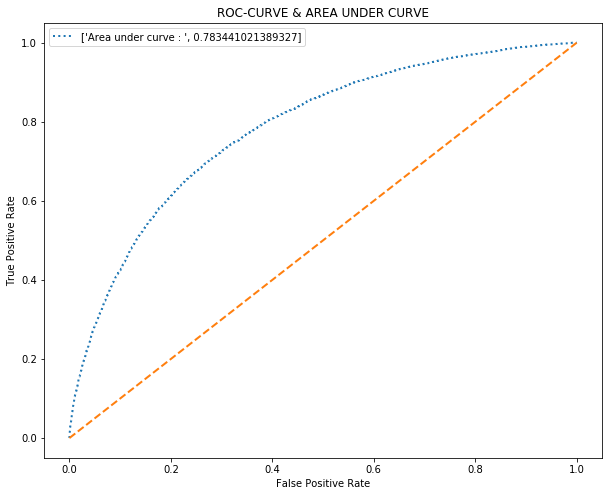

In [ ]:
print ("Accuracy score : ", accuracy)
print ("F1 score : ", f1_sc)
print ("AUC : ", auc_score)
print ("classification report :\n", classify_metrics)
    
fig = plt.figure(figsize=(10,8))
ax  = fig.add_subplot(111)
ax.plot(fpr,tpr,label   = ["Area under curve : ",auc_score],linewidth=2,linestyle="dotted")
ax.plot([0,1],[0,1],linewidth=2,linestyle="dashed")
plt.legend(loc="best")
plt.title("ROC-CURVE & AREA UNDER CURVE")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

The ROC AUC score of 0.7834 on the test data shows that K-fold cross validation was able to improve the model fitting parameters. 

---

<b> 4.5 Comparing feature importance </b>

We can compare the feature importances for the LightGBM model with the base case (logistic regression) model using the following function.  

In [ ]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

First, examining the top 15 features of the LightGBM model, we can see that it contains a number of features that were created from domain knowledge and through the automated feature engineering (DFS) process. Among the original features, a number of them are those that had a high loan default rate during exploratory data analysis.

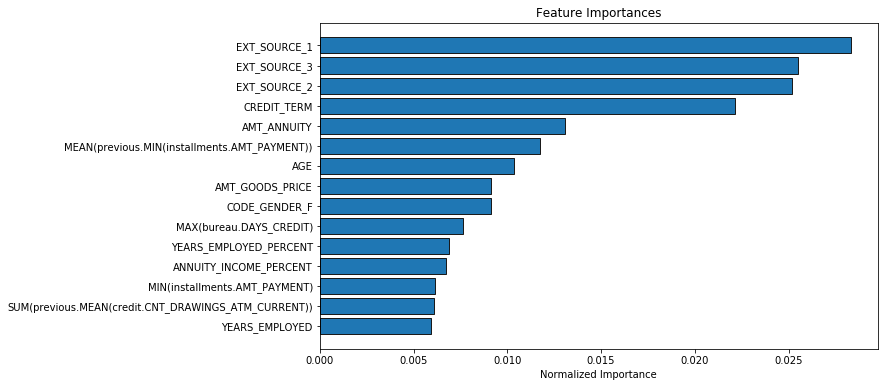

In [ ]:
# Show the feature importances for the new features
feature_importances_sorted = plot_feature_importances(feature_importances)

Looking at the top 15 features of the base case model, we can see that it contains a number of features that we saw had a high loan default rate during exploratory data analysis.

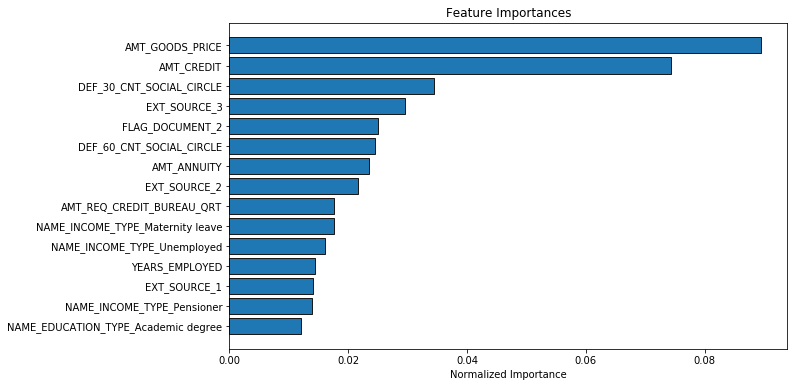

In [ ]:
# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances_logit_base)


---

### <b> 5.0 Hyperparameter Tuning </b>

After choosing LightGBM as the binary classifier, we can tune the hyperparameters for improving the model results through grid search, random search, and Bayesian optimization

---

<b> 5.1 Pre-processing </b>

The hyperparameter tuning process needs an objective function, the domain space, optimization algorithm to give the results.

First, the data is prepared for model training.

In [ ]:
random.seed(50)

#Remove possible JSON characters
df_undersampled_X = df_undersampled_X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df_undersampled_Y = df_undersampled_Y.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test_X = test_X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test_Y = test_Y.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# Create a training and testing dataset
train_set = lgb.Dataset(data = df_undersampled_X, label = df_undersampled_Y)
test_set = lgb.Dataset(data = test_X, label = test_Y)

The domain space is the range of hyperparameters over which the tuning process will be carried out. As seen below there are number of hyperparameters that can be modified. This grid can be used for grid/random search.

In [ ]:
# Hyperparameter grid
param_grid = {
    'boosting_type': ['gbdt', 'goss'],
    'num_leaves': list(range(20, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'is_unbalance': [True, False]
}

N_FOLDS = 5

The results of the tuning process will can be saved in the following dataframes

In [ ]:
# Dataframes for random and grid search
random_results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))

grid_results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))

The objective function is the one which takes the input hyperparameters to test different models and optimize the values over multiple iterations. The function use cross-validation for each major iteration to minimize the loss (1- ROC AUC score). It also saves the ROC AUC scores, and the hyperparameter values for each iteration, and the function can be used for all 3 methods. 

In [ ]:
# Objective function

def objective(hyperparameters):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization.
    """
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    print('current iteration:', ITERATION)
    
    # Using early stopping to find number of trees trained
    if 'n_estimators' in hyperparameters:
        del hyperparameters['n_estimators']
    
    if 'subsample' not in hyperparameters:  
    
        # Retrieve the subsample
        subsample = hyperparameters['boosting_type'].get('subsample', 1.0)
    
        # Extract the boosting type and subsample to top level keys
        hyperparameters['boosting_type'] = hyperparameters['boosting_type']['boosting_type']
        hyperparameters['subsample'] = subsample
    
        # Make sure parameters that need to be integers are integers
        for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
            hyperparameters[parameter_name] = int(hyperparameters[parameter_name])
            

    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)

    run_time = timer() - start
    
    # Extract the best score
    best_score = cv_results['auc-mean'][-1]
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = len(cv_results['auc-mean'])
    
    # Add the number of estimators to the hyperparameters
    hyperparameters['n_estimators'] = n_estimators

    # Write to the csv file ('a' means append)
    of_connection = open(OUT_FILE, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, hyperparameters, ITERATION, run_time, best_score])
    of_connection.close()
    
    # Dictionary with information for evaluation
    dict_return = {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION,
            'train_time': run_time, 'score': best_score, 'status': STATUS_OK}

    return dict_return

---

<b> 5.2 Grid Search </b>

The grid search algorithm iterates over the hyperparameters incrementally to explore the entire domain space. However, the exhaustive search is very time consuming and cannot be completed with finite computing resources. 

In [ ]:
def grid_search(param_grid, max_evals = MAX_EVALS):
    """Grid search algorithm (with limit on max evals)"""
    
    # Dataframe to store results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))
    
    # https://codereview.stackexchange.com/questions/171173/list-all-possible-permutations-from-a-python-dictionary-of-lists
    keys, values = zip(*param_grid.items())
    
    global ITERATION
    
    ITERATION = 0
    
    # Iterate through every possible combination of hyperparameters
    for v in itertools.product(*values):
        
        start = timer()
        
        # Create a hyperparameter dictionary
        hyperparameters = dict(zip(keys, v))
        
        # Set the subsample ratio accounting for boosting type
        hyperparameters['subsample'] = 1.0 if hyperparameters['boosting_type'] == 'goss' else hyperparameters['subsample']
        
        # Evalute the hyperparameters
        
        dict_return = objective(hyperparameters)
        eval_results = at(dict_return, 'score', 'hyperparameters', 'iteration')
           
        results.loc[ITERATION-1, :] = eval_results
        
        run_time = timer() - start
    
        print('run time:', run_time)
        
        # Normally would not limit iterations
        if ITERATION-1 > MAX_EVALS:
            break
       
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    
    return results

The created function can theoretically run on the entire domain space but is limited to maximum of 20 evaluations due to time and computational constraints.

In [ ]:
MAX_EVALS = 20

grid_results = grid_search(param_grid)

print('The best validation score was {:.5f}'.format(grid_results.loc[0, 'score']))
print('\nThe best hyperparameters were:')

current iteration: 1
run time: 1522.773884400005
current iteration: 2
run time: 1503.0661967999986
current iteration: 3
run time: 1498.1695688000036
current iteration: 4
run time: 1503.7519885000002
current iteration: 5
run time: 1503.0929772000018
current iteration: 6
run time: 1511.0171439000042
current iteration: 7
run time: 1507.4785205000007
current iteration: 8
run time: 1501.908500999998
current iteration: 9
run time: 1506.6445643999978
current iteration: 10
run time: 1503.959085800001
current iteration: 11
run time: 1520.9446762000007
current iteration: 12
run time: 1513.2455065999966
current iteration: 13
run time: 1504.3408496000047
current iteration: 14
run time: 1499.1914128999997
current iteration: 15
run time: 1484.2060864000014
current iteration: 16
run time: 1481.5503179000007
current iteration: 17
run time: 1479.785768099995
current iteration: 18
run time: 1481.1149571999995
current iteration: 19
run time: 1482.2159335000033
current iteration: 20
run time: 1485.9124900

In [ ]:
pprint.pprint(grid_results.loc[0, 'params'])

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.6,
 'is_unbalance': True,
 'learning_rate': 0.004999999999999999,
 'min_child_samples': 20,
 'n_estimators': 4376,
 'num_leaves': 20,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 0.5,
 'subsample_for_bin': 20000}


In [ ]:
# Get the best grid parameters
grid_best_params = grid_results.loc[0, 'params']

# Create, train, test model
model = lgb.LGBMClassifier(**grid_best_params, random_state = 42)
model.fit(df_undersampled_X, df_undersampled_Y)

preds = model.predict_proba(test_X)[:, 1]

print('The best model from grid search scores {:.5f} ROC AUC on the test set.'.format(roc_auc_score(test_Y, preds)))

The best model from grid search scores 0.78404 ROC AUC on the test set.


The best hyperparameters identified from the limited grid search and the ROC AUC score on test data are as given above

---

<b> 5.3 Random Search </b>

The random search algorithm selects hyperparameters from the domain space in a random manner. With limited resources, it can act as a preferred strategy due to a less exhaustive search and high possibility of finding good hyperparameter combinations 

In [ ]:
def random_search(param_grid, max_evals = MAX_EVALS):
    """Random search for hyperparameter optimization"""
    
    # Dataframe for results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                                  index = list(range(MAX_EVALS)))
    global ITERATION 
    
    ITERATION = 0
    
    # Keep searching until reach max evaluations
    for ITERATION in range(MAX_EVALS):
        
        start = timer()
        
        # Choose random hyperparameters
        hyperparameters = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        hyperparameters['subsample'] = 1.0 if hyperparameters['boosting_type'] == 'goss' else hyperparameters['subsample']

        # Evaluate randomly selected hyperparameters
        dict_return = objective(hyperparameters)
        eval_results = at(dict_return, 'score', 'hyperparameters', 'iteration')
        
        results.loc[ITERATION-1, :] = eval_results
        
        run_time = timer() - start
    
        print('run time:', run_time)
    
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    return results

The created function can be run for a long time to search optimal combinations in the domain space but is limited to maximum of 50 evaluations due to time and computational constraints.

In [ ]:
MAX_EVALS = 50

random_results = random_search(param_grid)

print('The best validation score was {:.5f}'.format(random_results.loc[0, 'score']))
print('\nThe best hyperparameters were:')

pprint.pprint(random_results.loc[0, 'params'])

current iteration: 1
run time: 86.69088769999507
current iteration: 2
run time: 89.37980359999347
current iteration: 3
run time: 226.03574050001043
current iteration: 4
run time: 56.482203699997626
current iteration: 5
run time: 181.76834759999474
current iteration: 6
run time: 557.4227027000015
current iteration: 7
run time: 168.50661969999783
current iteration: 8
run time: 135.31243079999695
current iteration: 9
run time: 34.05655379999371
current iteration: 10
run time: 49.77794659999199
current iteration: 11
run time: 1239.1488185999915
current iteration: 12
run time: 266.3286209999933
current iteration: 13
run time: 1577.2167353999976
current iteration: 14
run time: 231.87759069999447
current iteration: 15
run time: 162.45205449999776
current iteration: 16
run time: 119.27870629999961
current iteration: 17
run time: 35.075843899991014
current iteration: 18
run time: 772.6423830999993
current iteration: 19
run time: 52.23917729999812
current iteration: 20
run time: 1464.01428509999

In [ ]:
# Get the best parameters
random_best_params = random_results.loc[0, 'params']

# Create, train, test model
model = lgb.LGBMClassifier(**random_best_params, random_state = 42)
model.fit(df_undersampled_X, df_undersampled_Y)

preds = model.predict_proba(test_X)[:, 1]

print('The best model from random search scores {:.5f} ROC AUC on the test set.'.format(roc_auc_score(test_Y, preds)))

The best model from random search scores 0.78605 ROC AUC on the test set.


The best hyperparameters identified from the random search and the ROC AUC score on test data are as given above

---

<b> 5.4 Bayesian optimization </b>

The Bayesian method, unlike the previous uninformed methods uses the results of the previous iteration to decide the next hyperparameter combination in the domain space. It uses the [Hyperopt library](https://github.com/hyperopt/hyperopt) using the Tree Parzen Estimator algorithm to select the next hyperparameter values for evaluation in the objective function.

The search space is defined as required

In [ ]:
# Define the search space
space = {
    'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                             {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'is_unbalance': hp.choice('is_unbalance', [True, False]),
}

# Create the Tree Parzen Estimator algorithm
tpe_algorithm = tpe.suggest

# Record results
trials = Trials()

The created function can be run for a long time to search optimal combinations in the domain space but is limited to maximum of 50 evaluations due to time and computational constraints.

In [ ]:
MAX_EVALS = 50

# Create a new file and open a connection
OUT_FILE = 'bayesian_trials.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
writer.writerow(headers)
of_connection.close()

# Record results
trials = Trials()

global ITERATION

ITERATION = 0 

#function to call objective function and choose hyperparameters

best = fmin(fn = objective, space = space, algo = tpe.suggest,
            trials = trials, max_evals = MAX_EVALS)

# Sort the trials with lowest loss (highest AUC) first
trials_dict = sorted(trials.results, key = lambda x: x['loss'])

print('Finished, best results')
print(trials_dict[:1])

# Save the trial results
with open('trials.json', 'w') as f:
    f.write(json.dumps(trials_dict))

current iteration:
1
current iteration:
2
current iteration:
3
current iteration:
4
current iteration:
5
current iteration:
6
current iteration:
7
current iteration:
8
current iteration:
9
current iteration:
10
current iteration:
11
current iteration:
12
current iteration:
13
current iteration:
14
current iteration:
15
current iteration:
16
current iteration:
17
current iteration:
18
current iteration:
19
current iteration:
20
current iteration:
21
current iteration:
22
current iteration:
23
current iteration:
24
current iteration:
25
current iteration:
26
current iteration:
27
current iteration:
28
current iteration:
29
current iteration:
30
current iteration:
31
current iteration:
32
current iteration:
33
current iteration:
34
current iteration:
35
current iteration:
36
current iteration:
37
current iteration:
38
current iteration:
39
current iteration:
40
current iteration:
41
current iteration:
42
current iteration:
43
current iteration:
44
current iteration:
45
current iteration:


In [ ]:
# Get the best parameters
Bayesian_best_params = trials_dict[0]['hyperparameters']

# Create, train, test model
model = lgb.LGBMClassifier(**Bayesian_best_params, random_state = 42)
model.fit(df_undersampled_X, df_undersampled_Y)

preds = model.predict_proba(test_X)[:, 1]

print('The best model from Bayesian search scores {:.5f} ROC AUC on the test set.'.format(roc_auc_score(test_Y, preds)))

The best model from Bayesian search scores 0.78366 ROC AUC on the test set.


The best hyperparameters identified from the Bayesian optimization process and the ROC AUC score on test data are as given above

---

The best model predictions can be saved in a csv file

In [ ]:
#Save predictions

final_predictions_test = pd.DataFrame({'SK_ID_CURR': test_Y.index, 'TARGET_actual': test_Y, 'TARGET_pred': preds})
final_predictions_test.to_csv('final_predictions_test.csv', index = False)

---

<b> 5.5 Comparison of the tuning methods </b>

The ROC AUC validation scores from all three methods for different iterations can be compared to see trends

In [ ]:
# Dataframe of Grid search scores

scores_g = pd.DataFrame({'ROC_AUC': grid_results['score'], 'iteration': grid_results['iteration'], 'search': 'Grid'})

scores_g['ROC_AUC'] = scores_g['ROC_AUC'].astype(np.float32)
scores_g['iteration'] = scores_g['iteration'].astype(np.int32)

scores_g.head()

ROC_AUC  iteration search
0  0.778541          1   Grid
1  0.778541          2   Grid
2  0.778541         21   Grid
3  0.778541         20   Grid
4  0.778541         19   Grid

In [ ]:
# Dataframe of Random scores

scores_r = pd.DataFrame({'ROC_AUC': random_results['score'], 'iteration': random_results['iteration'], 'search': 'Random'})

scores_r['ROC_AUC'] = scores_r['ROC_AUC'].astype(np.float32)
scores_r['iteration'] = scores_r['iteration'].astype(np.int32)

scores_r.head()

ROC_AUC  iteration  search
0  0.780280         11  Random
1  0.779592         20  Random
2  0.779368         37  Random
3  0.779290         46  Random
4  0.778911         13  Random

In [ ]:
score_b =[]
iteration_b=[]

for key in range(len(trials_dict)):
    score_b.append(trials_dict[key]['score'])
    iteration_b.append(trials_dict[key]['iteration'])

In [ ]:
# Dataframe of Bayesian scores

scores_b = pd.DataFrame({'ROC_AUC': score_b, 'iteration': iteration_b, 'search': 'Bayesian'})

scores_b['ROC_AUC'] = scores_b['ROC_AUC'].astype(np.float32)
scores_b['iteration'] = scores_b['iteration'].astype(np.int32)
scores_b.head()

ROC_AUC  iteration    search
0  0.779515         31  Bayesian
1  0.779331         30  Bayesian
2  0.779224         27  Bayesian
3  0.779212         35  Bayesian
4  0.778941         21  Bayesian

The best validation scores for each method are identified

In [ ]:
best_grid_score = scores_g.iloc[scores_g['ROC_AUC'].idxmax(), :].copy()
best_random_score = scores_r.iloc[scores_r['ROC_AUC'].idxmax(), :].copy()
best_bayes_score = scores_b.iloc[scores_b['ROC_AUC'].idxmax(), :].copy()

The scores for each method are combined and plotted for increasing iterations

In [ ]:
all_scores = pd.concat([scores_b.assign(dataset='Bayesian'), scores_r.assign(dataset='Random'), scores_g.assign(dataset='Grid')])

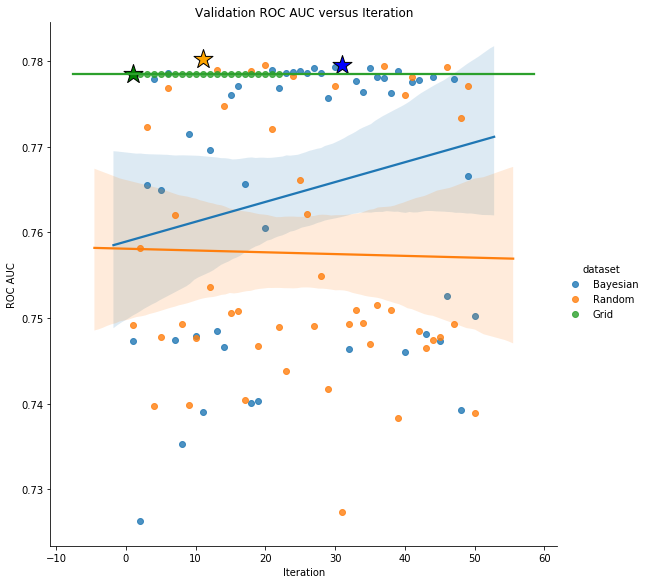

In [ ]:
# Plot of scores over the course of searching
sns.lmplot('iteration', 'ROC_AUC', data = all_scores, size = 8, hue='dataset');
plt.scatter(best_bayes_score['iteration'], best_bayes_score['ROC_AUC'], marker = '*', s = 400, c = 'blue', edgecolor = 'k')
plt.scatter(best_random_score['iteration'], best_random_score['ROC_AUC'], marker = '*', s = 400, c = 'orange', edgecolor = 'k')
plt.scatter(best_grid_score['iteration'], best_grid_score['ROC_AUC'], marker = '*', s = 400, c = 'green', edgecolor = 'k')
plt.xlabel('Iteration'); plt.ylabel('ROC AUC'); plt.title("Validation ROC AUC versus Iteration");

We can the behaviors of each tuning method with increasing iterations in the above figure. The grid search scores do not differ much since during each iteration, only one hyperparameter is incrementally changed. The random search scores are scattered with no noticeable trend but have the highest validation ROC AUC score simply by finding a favorable combination. The Bayesian search can be observed to have progressively better scores with increasing iterations as expected, and if the number of iterations were increased could have surpassed the score from random method